# Business Context

## Introduction

**Insurance All Company**

Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

## Challenge

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

## Deliveriables

1. Main insights about the features more relevant from clients interesteds in purchase a car insurance.

2. What's the percentage of clients interesteds in purchase a car insurance, the sales team will be able to contact 10.000 customers?

3. If the capacity of the sales team growh up to 20.000 calls, which will be the percentage of clients interesteds in purchase a car insurance that the sales team will be able to contact?

4. How many call the sales team will need to do to contact 80% of the customers interests in purchase a car insurance?

5. What's the minimum score I need to address to get the greatest return?

## Solution Plan

1. Clean the dataset


2. Derivate New Features


3. Balance Dataset


4. Analysis Dataset


5. Select Features


6. Machine Learning Modeling

# 0.0. Imports

In [1]:
# data manipulation
import pandas                as pd
import numpy                 as np
import random                as rd

# data visualization
from scipy                import stats           as ss
import matplotlib.pyplot     as plt
import seaborn               as sns
from matplotlib              import gridspec
import scikitplot            as skplt

# data preparation
import sklearn.preprocessing   as pp
from sklearn                 import neighbors as nh

# feature selection
from sklearn.feature_selection import RFE
from boruta                    import BorutaPy

# machine learning models
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LogisticRegression
from sklearn.naive_bayes     import GaussianNB
from lightgbm                import LGBMClassifier
from sklearn.neural_network  import MLPClassifier
from sklearn                 import neighbors    as nh
import xgboost                                   as xgb
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model    import LogisticRegression

# metrics
from sklearn.metrics         import accuracy_score, balanced_accuracy_score, classification_report,cohen_kappa_score,recall_score,f1_score,roc_auc_score, plot_precision_recall_curve, precision_score,roc_curve, top_k_accuracy_score, roc_auc_score
import sklearn.metrics                                 as m  
from scikitplot              import metrics            as mt
from sklearn                 import model_selection    as ms 
from sklearn.calibration     import calibration_curve,CalibratedClassifierCV
from yellowbrick.classifier  import PrecisionRecallCurve

# stetical
from IPython.display         import Image
from IPython.core.display    import HTML
from boruta                  import BorutaPy
import warnings
import requests
import inflection
import pickle

# supressing scientific conotations
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# supressing warnings
warnings.filterwarnings('ignore')

# 0.1. Helper Functions

## 0.1.1. Settings

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [26, 15]
    plt.rcParams['font.size'] = 20
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.1.2. Graphics

In [4]:
def corr_cramer_v(categorical_attributes):
    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(categorical_attributes[ref],categorical_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
    return corr_dict

In [5]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr=k - (k-1)**2/(n-1) 
    rcorr=r - (r-1)**2/(n-1) 
    
    v = np.sqrt( (chi2corr/n) / (min (kcorr-1,rcorr-1)))
    return v    

## 0.1.3. Metrics

In [6]:
# validation data
def validation_data(trained_model, data_val):
    # separate X and Y data:
    xval = data_val.drop(['id', 'response'], axis=1)
    yval = data_val.response
    
    # predict_proba:
    yhat_proba = trained_model.predict_proba(xval)
    
    # transform yhat_proba to 1D-array
    yhat_proba_1d = yhat_proba[:, 1].tolist()
    
    # include in dataframe
    validation_data = data_val.copy()
    validation_data['score'] = yhat_proba_1d
    # sort
    validation_data = validation_data.sort_values('score', ascending=False)
    # precision and recall
    validation_data = validation_data.reset_index(drop=True)
    validation_data['n_samples'] = validation_data.index + 1
    validation_data['precision_at_k'] = validation_data['response'].cumsum() / validation_data['n_samples']
    validation_data['recall_at_k'] = validation_data['response'].cumsum() / validation_data['response'].sum()
    
    return validation_data

In [7]:
def validation_metrics(validated_data, k):    
    return pd.DataFrame({'precision_at_{}'.format(k):validated_data.loc[k, 'precision_at_k'],
                         'recall_at_{}'.format(k):validated_data.loc[k, 'recall_at_k']},
                         index=['ranking_metrics']).T

In [8]:
def numerical_metrics(numerical_attributes):
    #ct = central tendency
    ct_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    ct_median = pd.DataFrame(numerical_attributes.apply(np.median)).T

    #d = dispersion
    d_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    d_min = pd.DataFrame(numerical_attributes.apply(min)).T
    d_max = pd.DataFrame(numerical_attributes.apply(max)).T
    d_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    d_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    d_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    na_resume = pd.concat([d_min,d_max,d_range,ct_mean,ct_median,d_std,d_skew,d_kurtosis]).T.reset_index()
    na_resume.columns=['Attributes','Min','Max','Range','Mean','Median','STD','Skew','Kurtosis']

    return na_resume

In [9]:
def regression_metrics(model,y_val,yhat,verbose =1):
    
    model = pd.DataFrame([model]).T
    
    #Accuracy
    acc = m.accuracy_score(y_val,yhat)
    accdf = pd.DataFrame([acc]).T

    #Balanced Accuracy
    balanced= m.balanced_accuracy_score(y_val,yhat)
    balanceddf = pd.DataFrame([balanced]).T

    #Kappa Metrics
    kappa= m.cohen_kappa_score(y_val, yhat)
    kappadf = pd.DataFrame([kappa]).T
    
    metrics = pd.concat([model,accdf,balanceddf,kappadf]).T.reset_index()
    metrics.columns=['Index','Model','Accuracy','Balanced Accuracy','Kappa Score']
    metrics.drop(['Index'],axis=1)
    if verbose ==1:
        print('Accuracy: {}'.format(acc))
        print('Balanced Accuracy: {}'.format(balanced))
        print('Kappa Score: {}'.format(kappa))
        #Classification Report
        print(m.classification_report(y_val,yhat))
        # Confision Matrix
        mt.plot_confusion_matrix(y_val,yhat,normalize=False,figsize=(12,12))
        
    return metrics

In [10]:
def multi_class_metrics(model,y_val,yhat,verbose =1):
    
    model = pd.DataFrame([model]).T

    #Precision Score
    precision= m.precision_score(y_val, yhat)
    precisiondf = pd.DataFrame([precision]).T
    
    #Recall Score
    recall= m.recall_score(y_val, yhat)
    recalldf = pd.DataFrame([recall]).T
    
    #F1 Score
    f1= m.f1_score(y_val, yhat)
    f1df = pd.DataFrame([f1]).T
    
    #MAtthews Correlation
    mcc=m.matthews_corrcoef(y_val,yhat)
    mccdf=pd.DataFrame([mcc])    
    
    metrics = pd.concat([model,precisiondf,recalldf,f1df,mccdf]).T.reset_index()
    metrics.columns=['Index','Model','Precision Score','Recall Score','F1 Score','Matthew Correlation Score']
    metrics.drop(['Index'],axis=1)
    if verbose ==1:
        print('Precision Score: {}'.format(precision))
        print('Recall Score: {}'.format(recall))
        print('F1 Score: {}'.format(f1))
        print('Matthew Correlation Score: {}'.format(mcc))
        #Classification Report
        print(m.classification_report(y_val,yhat))
        # Confision Matrix
        mt.plot_confusion_matrix(y_val,yhat,normalize=False,figsize=(12,12))
        
    return metrics

In [11]:
def ranking_class_metrics(model,y_val,yhat,verbose =1):
    
    model = pd.DataFrame([model]).T

    #AUC_ROC
    roc=roc_auc_score(y_val,yhat)
    rocdf=pd.DataFrame([roc])
    
    #topk Score
    knum=y_val.value_counts().count()-1
    topk=top_k_accuracy_score(y_val,yhat,k=knum)
    topkdf=pd.DataFrame([topk])     
    
    metrics = pd.concat([model,rocdf,topkdf]).T.reset_index()
    metrics.columns=['Index','Model','ROC AUC','Top K Score']
    metrics.drop(['Index'],axis=1)
    if verbose ==1:
        print('ROC AUC: {}'.format(roc))
        print('Top K Score: {}'.format(topk))
        #Classification Report
        print(m.classification_report(y_val,yhat))
        # Confision Matrix
        mt.plot_confusion_matrix(y_val,yhat,normalize=False,figsize=(12,12))
        
    return metrics

## 0.1.4. Models

In [12]:
def cross_validation(num_folds,modelName,model,x,y,metric):
    kfold=ms.StratifiedKFold(n_splits=num_folds,shuffle=True,random_state=42)

    cv_rf_metrics_list=pd.DataFrame()

    i=1
    
    metrics = pd.DataFrame()
    
    for train_cv,val_cv in kfold.split(x,y):
        print('Fold Number {}/{}'.format(i,num_folds))

        x_train_fold = x.iloc[train_cv]
        y_train_fold = y.iloc[train_cv]

        x_val_fold = x.iloc[val_cv]
        y_val_fold = y.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model=model_fit.predict(x_val_fold)
        #metrics = model_metrics(modelName,y_val_fold,yhat_model,0)
        
        if metric=='regression':
            metrics=metrics.append(regression_metrics(model.__class__.__name__,y_val_fold,yhat_model,verbose=0))
        elif metric=='multiClass':
            metrics=metrics.append(multi_class_metrics(model.__class__.__name__,y_val_fold,yhat_model,verbose=0))
        elif metric=='binaryClass':
            metrics=metrics.append(ranking_class_metrics(model.__class__.__name__,y_val_fold,yhat_model,verbose=0))
        else:
            metrics = print("don't found this parameter")

        i+=1
    return metrics

In [13]:
def models_train(models,x_train,y_train,x_test,y_test,predict='predict',metric='regression',verbose=1):
    metrics=pd.DataFrame()
    for model in models:
        print(model.__class__.__name__)
        model.fit(x_train,y_train)
        if predict=='predict':
            yhat=model.predict(x_test)
        elif predict=='predict_proba':
            yhat=model.predict_proba(x_test)
            yhat=yhat[:, 1]
        
        if metric=='regression':
            metrics=metrics.append(regression_metrics(model.__class__.__name__,y_test,yhat,verbose))
        elif metric=='multiClass':
            metrics=metrics.append(multi_class_metrics(model.__class__.__name__,y_test,yhat,verbose))
        elif metric=='binaryClass':
            metrics=metrics.append(ranking_class_metrics(model.__class__.__name__,y_test,yhat,verbose))
            
    return metrics

# 0.2. Loading Data

In [14]:
# loading train data
df_tt = pd.read_csv('data/train.csv')

### 0.2.1. Checking Proportions

In [15]:
# proportion to sample no response
len(df_tt[df_tt['Response'] == 0])/2 - 30000

137199.5

In [16]:
# proportion to sample with response
len(df_tt[df_tt['Response'] == 1])

46710

### 0.2.2. Sampling Dataset

My machine don't has sufficient ram memory to run all the lines, then I decided to make a sample.

In [17]:
# sampling dataset
df_tt1 = df_tt[df_tt['Response'] == 0].sample(127199)
df_tt2 = df_tt[df_tt['Response'] == 1].sample(46710)

# concatning dataset
df_train = pd.concat([df_tt1, df_tt2], axis=0)

# 1.0. Step 01 - Data Description

In [18]:
# copying train dataset
df1 = df_train.copy()

## 1.1. Rename Columns

In [19]:
# checking columns' name
df1.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [20]:
# creating old columns variable
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

# creating sknakecase variable
snakecase = lambda x: inflection.underscore(x)

# creting snakecase columns
cols_new = list(map(snakecase, cols_old))

# renaming
df1.columns = cols_new

# checking columns
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 1.2. Data Dimensions

In [21]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 173909
Number of Cols: 12


## 1.3. Checking NA

In [22]:
# checking NA rows
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4. Checking Dtypes

In [23]:
# checking dtypes
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.5. Changing Dtypes

In [24]:
# region_code to int64
df1['region_code'] = df1['region_code'].astype(int)

# policy_sales_channel
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)

## 1.6. Descriptive Statistical

In [25]:
# separating numerical attributes
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# separating categorical attributes
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

In [26]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, knew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([ct1, ct2, d1, d2, d3, d4, d5, d6]).T.reset_index()
m.columns = ['attributes', 'mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']
m

,attributes,mean,median,std,min,max,range,skew,kurtosis
0,id,190354.75,190116.00,109988.84,1.00,381109.00,381108.00,0.00,-1.20
1,age,39.61,38.00,15.11,20.00,85.00,65.00,0.59,-0.58
2,driving_license,1.00,1.00,0.04,0.00,1.00,1.00,-23.36,543.63
3,region_code,26.47,28.00,13.01,0.00,52.00,52.00,-0.14,-0.80
4,previously_insured,0.38,0.00,0.49,0.00,1.00,1.00,0.48,-1.77
5,annual_premium,30776.23,31873.00,17581.53,2630.00,540165.00,537535.00,2.18,44.22
6,policy_sales_channel,108.72,124.00,54.99,1.00,163.00,162.00,-0.78,-1.18
7,vintage,154.30,154.00,83.64,10.00,299.00,289.00,0.00,-1.20
8,response,0.27,0.00,0.44,0.00,1.00,1.00,1.04,-0.91


## 1.7. Checking Outliers From Numerical Attributes

Checking the annual_premium distribution because the statistic descriptive from it looks distorted.

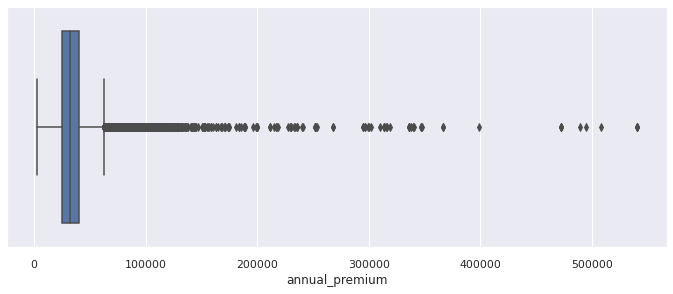

In [27]:
# oldbalance_org
plt.subplot(3,2,2)
sns.boxplot(df1['annual_premium']);

## 1.8. Checking Outliers From Categorical Attributes

Checking outliers from annual_premium by categorical attributes

In [28]:
# num of categorical types
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

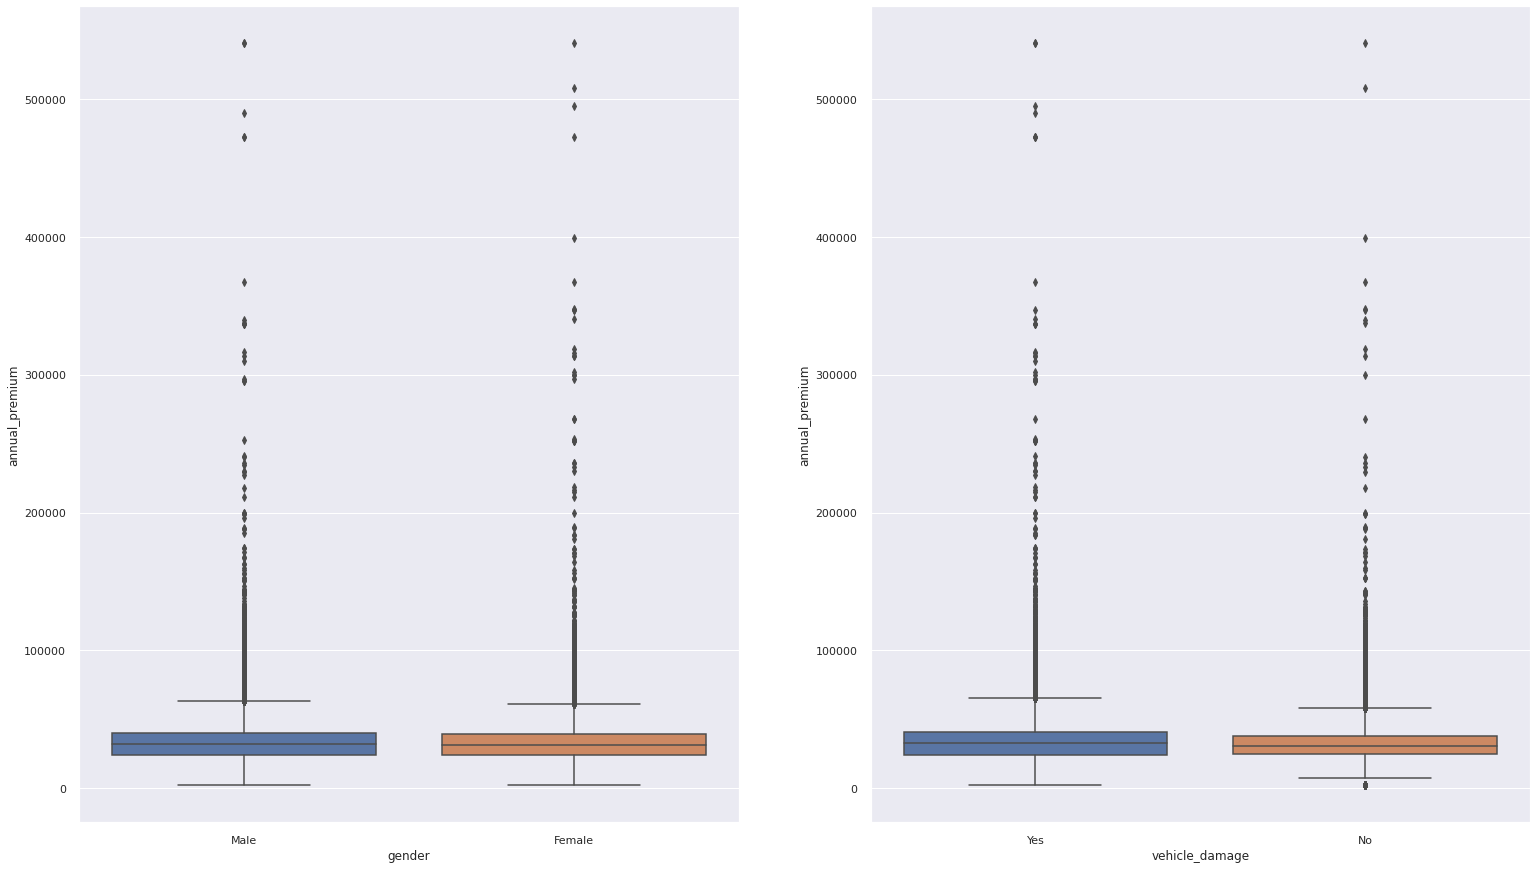

In [29]:
# Checking Outliers By Type
plt.subplot(1, 2, 1)
sns.boxplot(x='gender', y='annual_premium', data=df1);

# Checking Outliers By Type
plt.subplot(1, 2, 2)
sns.boxplot(x='vehicle_damage', y='annual_premium', data=df1);

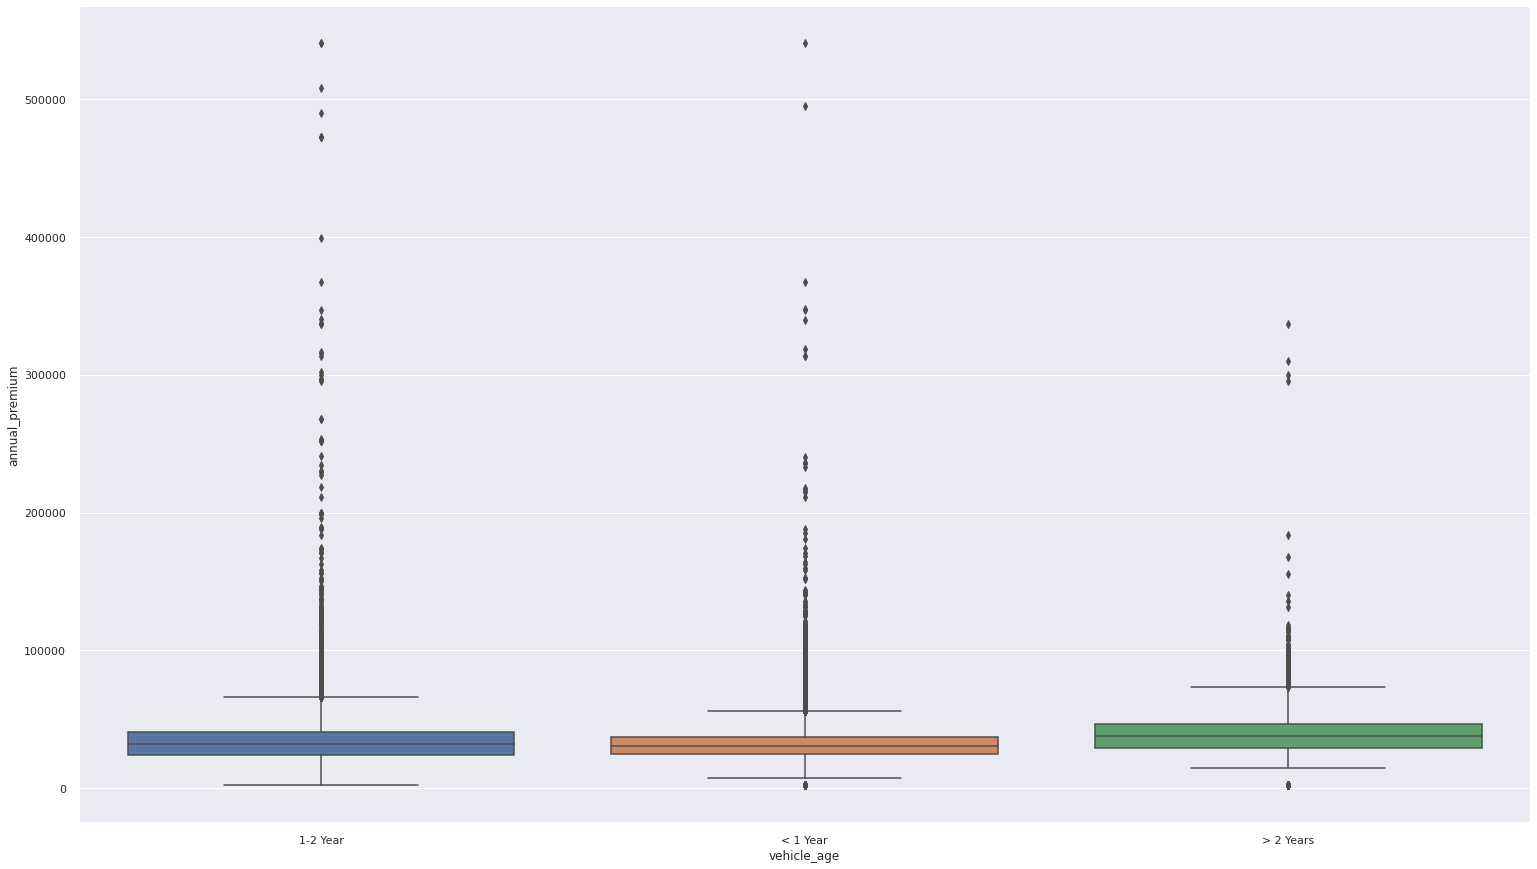

In [30]:
# Checking Outliers By Date
sns.boxplot(x='vehicle_age', y='annual_premium', data=df1);

The outliers present aren't foccused in one situation, but good distributed.

# 2.0. Step 02 - Feature Engineering

In [31]:
# copying train dataset
df2 = df1.copy()

## 2.1. Mindmap

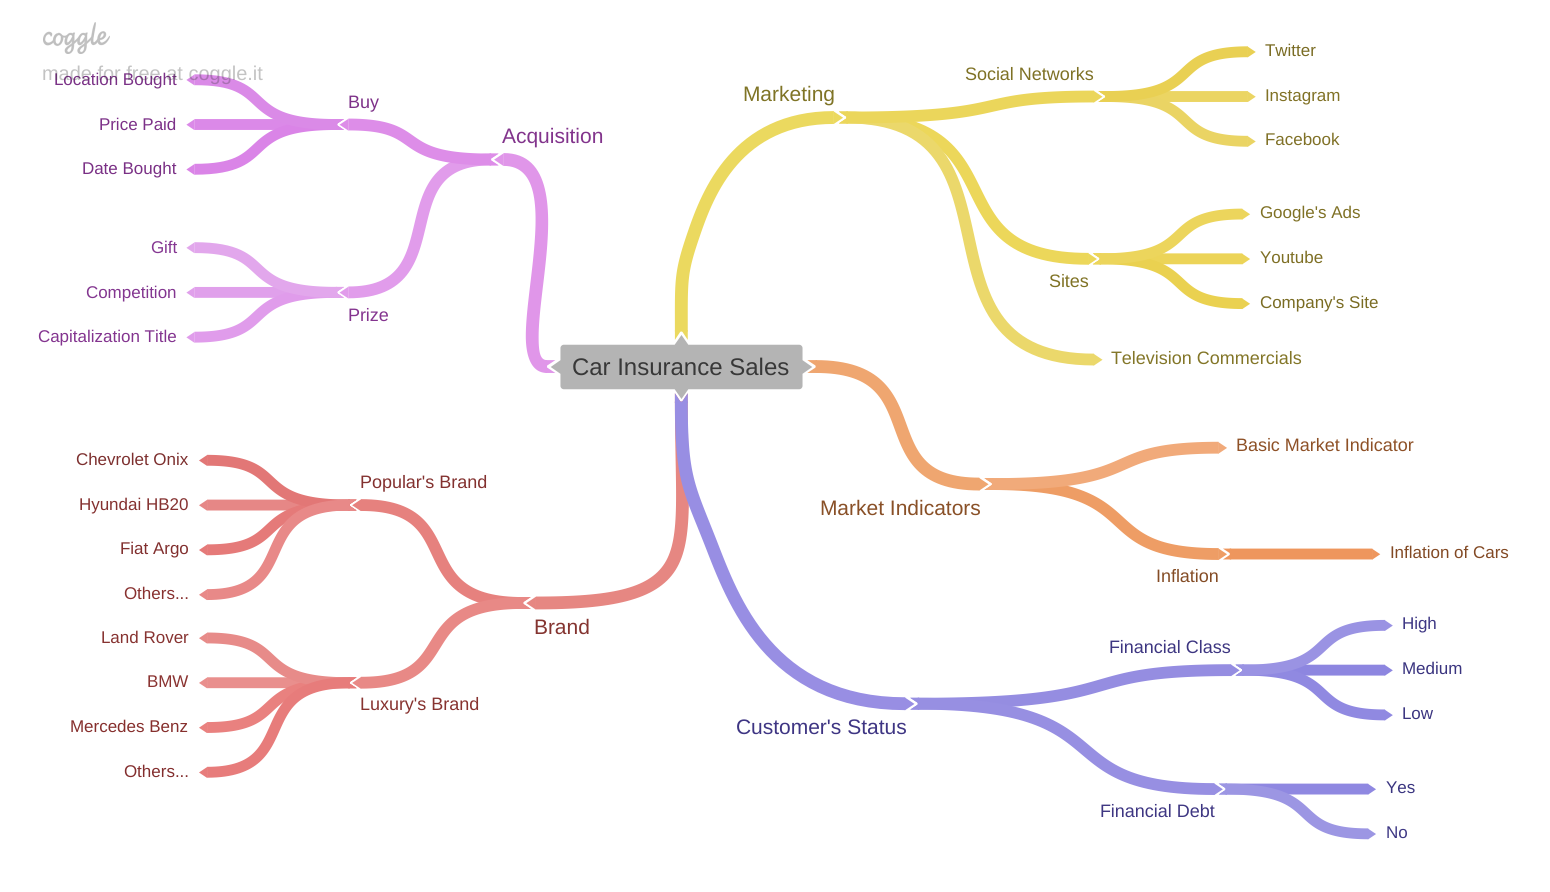

In [32]:
Image('Car_Insurance_Sales.png')

## 2.2. Studying Features To Derivate

### 2.2.1. Studying Risk Regions

Here I considered regions with more than 50% of vehicles damaged, because this represents more than half.

In [33]:
# summing vehicle_damage by region_code
aux = df2.copy()
aux['vehicle_damage'] = aux['vehicle_damage'].apply(lambda x: 0 if x == 'No' else 1)
aux1 = aux[['region_code', 'vehicle_damage']].groupby('region_code').sum().reset_index()

# counting regions' appearences
df2['region'] = df2['region_code'].copy()
aux4 = df2[['region_code', 'region']].groupby('region_code').count().reset_index().drop('region_code', axis=1)
aux5 = pd.concat([aux4, aux1], axis=1)

# derivating the rate of risk region
aux5['risk_region_rate'] = aux5['vehicle_damage']/aux5['region']

# showing risk regions
aux6 = aux5[aux5['risk_region_rate'] > 0.5]
aux6['region_code'].unique()

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 12, 13, 18, 19, 20, 22, 23, 24,
       26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45,
       46, 47, 48, 49, 51, 52])

In [34]:
# creting risk_regions variable
risk_regions = [0,  1,  4,  5,  7, 19, 20, 23, 24, 26, 28, 31, 34, 37, 38, 39, 40,
       42, 43, 47, 48, 49, 51]

## 2.3. Feature Engineering (Feature Derivation)

In [35]:
# creating function
def feature_engineering(df, reg_risk):
    
    # risk_age
    df['risk_age'] = df['age'].apply(lambda x: 0 if x > 25 else 1)
    
    # more_than_40_years
    df['more_than_40_years'] = df['age'].apply(lambda x: 'yes' if x > 40 else 'no')
    
    #------------------------------------------------------------------------------------------------------
    # summing vehicle_damage by region_code
    aux = df.copy()
    aux['vehicle_damage'] = aux['vehicle_damage'].apply(lambda x: 0 if x == 'No' else 1)
    aux1 = aux[['region_code', 'vehicle_damage']].groupby('region_code').sum().reset_index()

    # counting regions' appearences
    df['region'] = df['region_code'].copy()
    aux4 = df[['region_code', 'region']].groupby('region_code').count().reset_index().drop('region_code', axis=1)
    aux5 = pd.concat([aux4, aux1], axis=1)

    # derivating the rate of risk region
    aux5['risk_region_rate'] = aux5['vehicle_damage']/aux5['region']

    # derivating rate - region variable to merge
    aux7 = aux5.copy()
    aux7 = aux7.drop(['region', 'vehicle_damage'], axis=1)
    aux7['risk_region_rate'] = aux7['risk_region_rate']*1000
    
    # merging datasets
    df = pd.merge(aux, aux7, how='left', on='region_code')

    #---------------------------------------------------------------------------------------------------------
    
    # risk_region
    df['risk_region'] = df['region_code'].apply(lambda x: 'Yes' if x in reg_risk else 'No')
    
    return df

# using the function in train dataset
df2 = feature_engineering(df2, risk_regions)

## 2.3. Hyphotesis List

**H1.** Men have more chance to purchase a health insurance than women.

**H2.** People with more than 40 years have more chance to purchase health insurance than youngest people.

**H3.** People with driving license have more chance to purchase a health insurance.

**H4.** People that previously insured a health insurance have more chance to purchase a health insurance.

**H5.** People with vehicles with a age less than 2 have more chance to purchase a health insurance.

**H6.** People with a annual premium lower than 41000.00 have more chance to purchase a health insurance.

**H7.** People associated to the company for more than 200 days have more chance to purchase a health insurance.

**H8.** People that lives in a risk region have more chance to purchase a car insurance.

# 3.0. Step 03 - Exploratory Data Analysis

In [36]:
# copying dataset
df3 = df2.copy()

## 3.1. Univariable Data Analysis

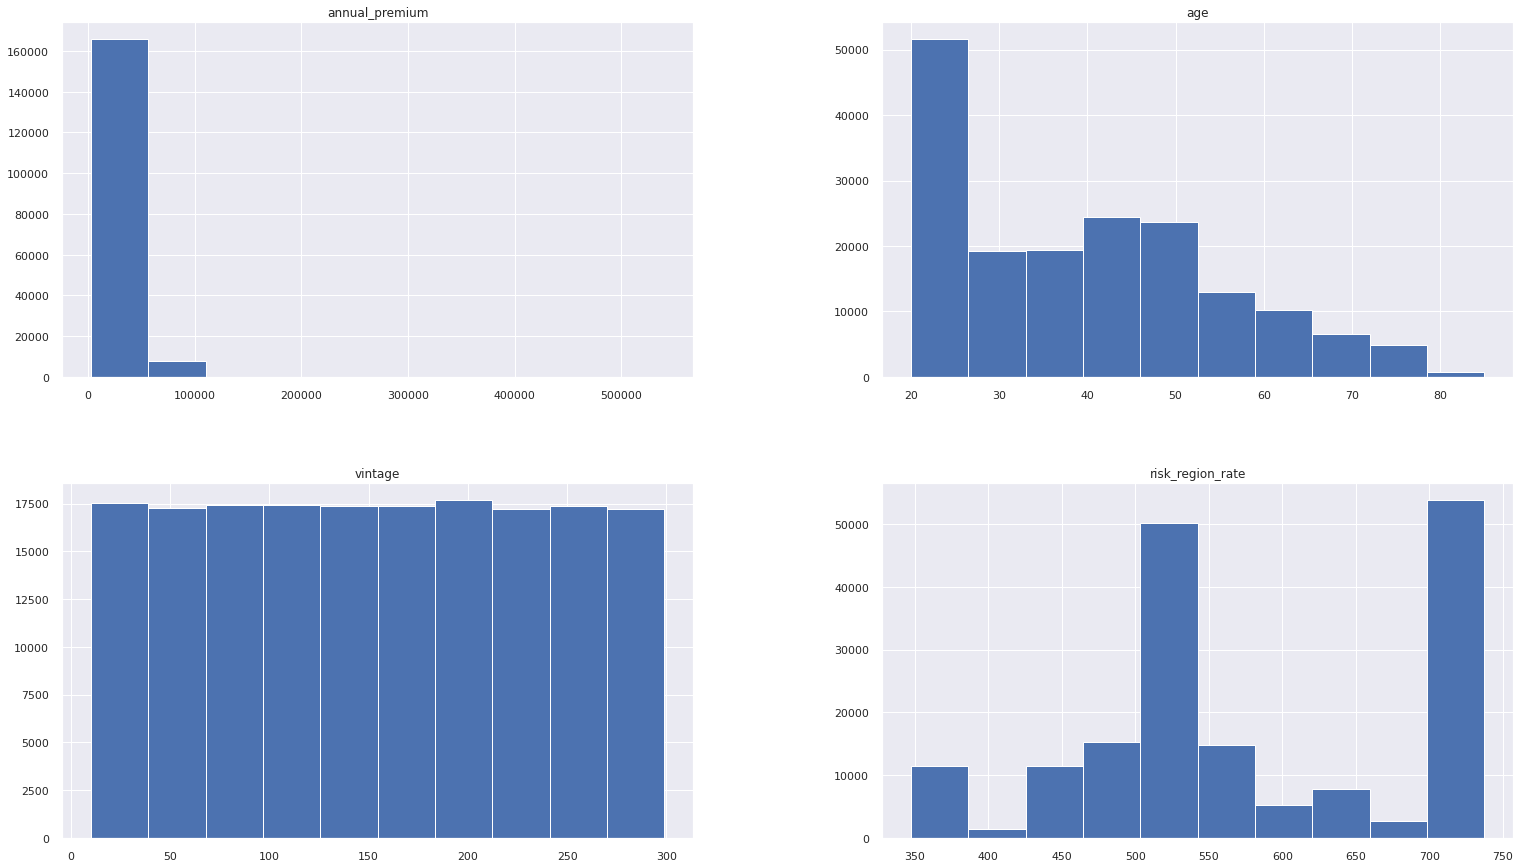

In [37]:
# checking variables' distribution
df3[['annual_premium', 'age', 'vintage', 'risk_region_rate']].hist();

The distributions of this features aren't like a normal, then I will need to have some attention on there after.

## 3.2. Bivariable Data Analysis

###  H1. Men have more chance to purchase a car insurance than women.
**TRUE** Men have 22.14% more chance to purchase a car insurance than women.

      **Men have more 22.14% chance to buy a health insurance than women.**


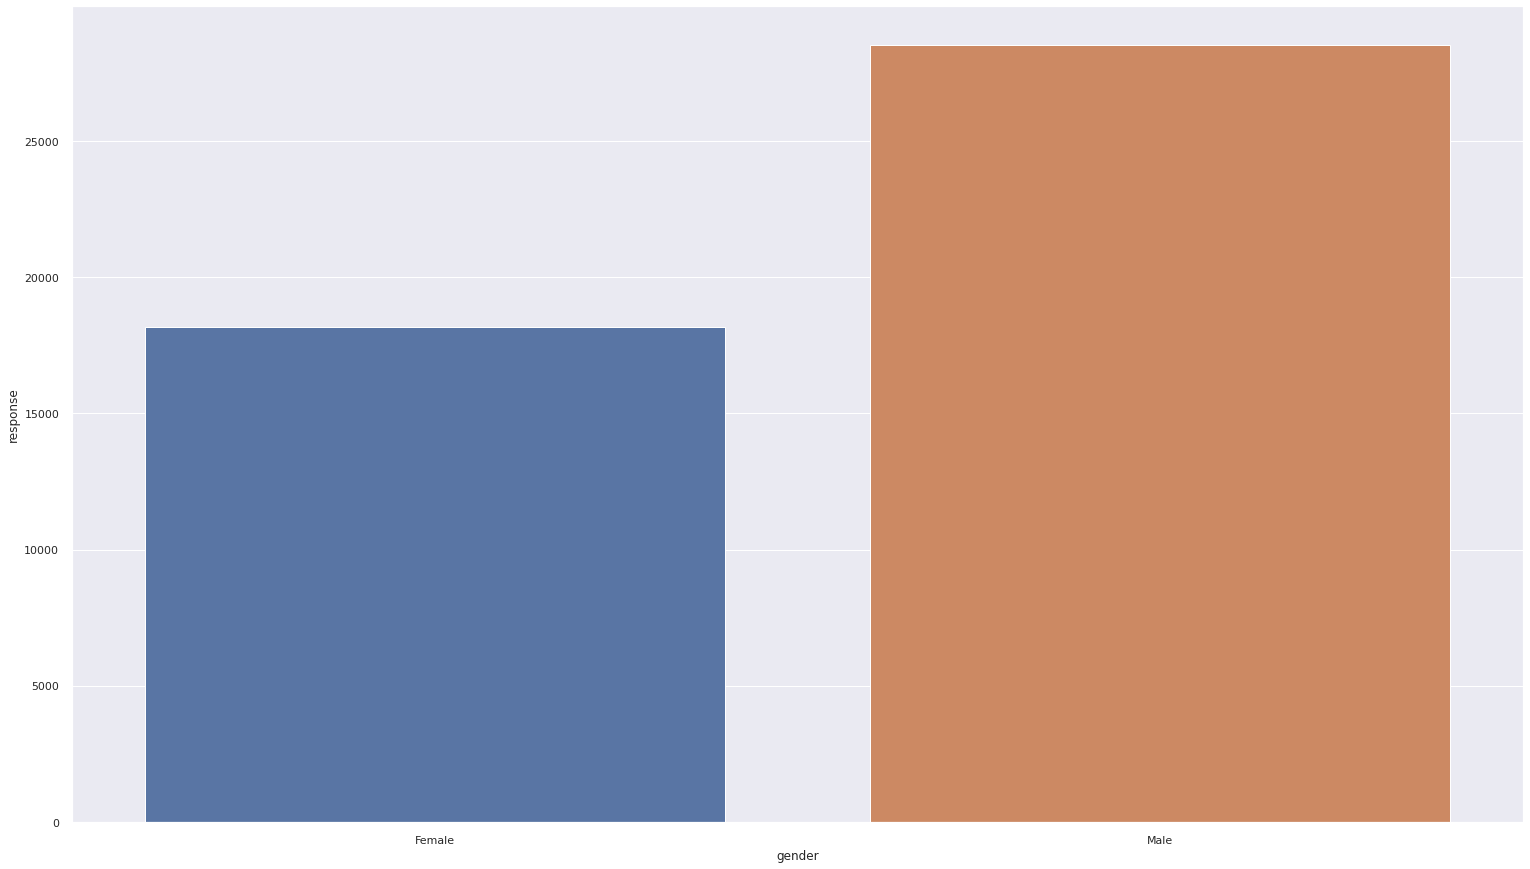

In [38]:
# grouping variables
aux1 = df3[['gender', 'response']].groupby('gender').sum().reset_index()

# calculing the percentual
tot1 = aux1['response'].sum()
perc1 = int(aux1['response'].head(1))/tot1
perc2 = int(aux1['response'].tail(1))/tot1
maj1 = 100*(perc2 - perc1)
print('      **Men have more {:.2f}% chance to buy a health insurance than women.**'.format(maj1))

# ploting graph
sns.barplot(data=aux1, x='gender', y='response');

### H2. People with more than 40 years have more chance to purchase car insurance than youngest people.
**TRUE** People with more than 40 years have more chance to purchase a car insurance than youngest people.

      **People with more than 40 years have more 19.59% chance to buy a health insurance than youngest people.**


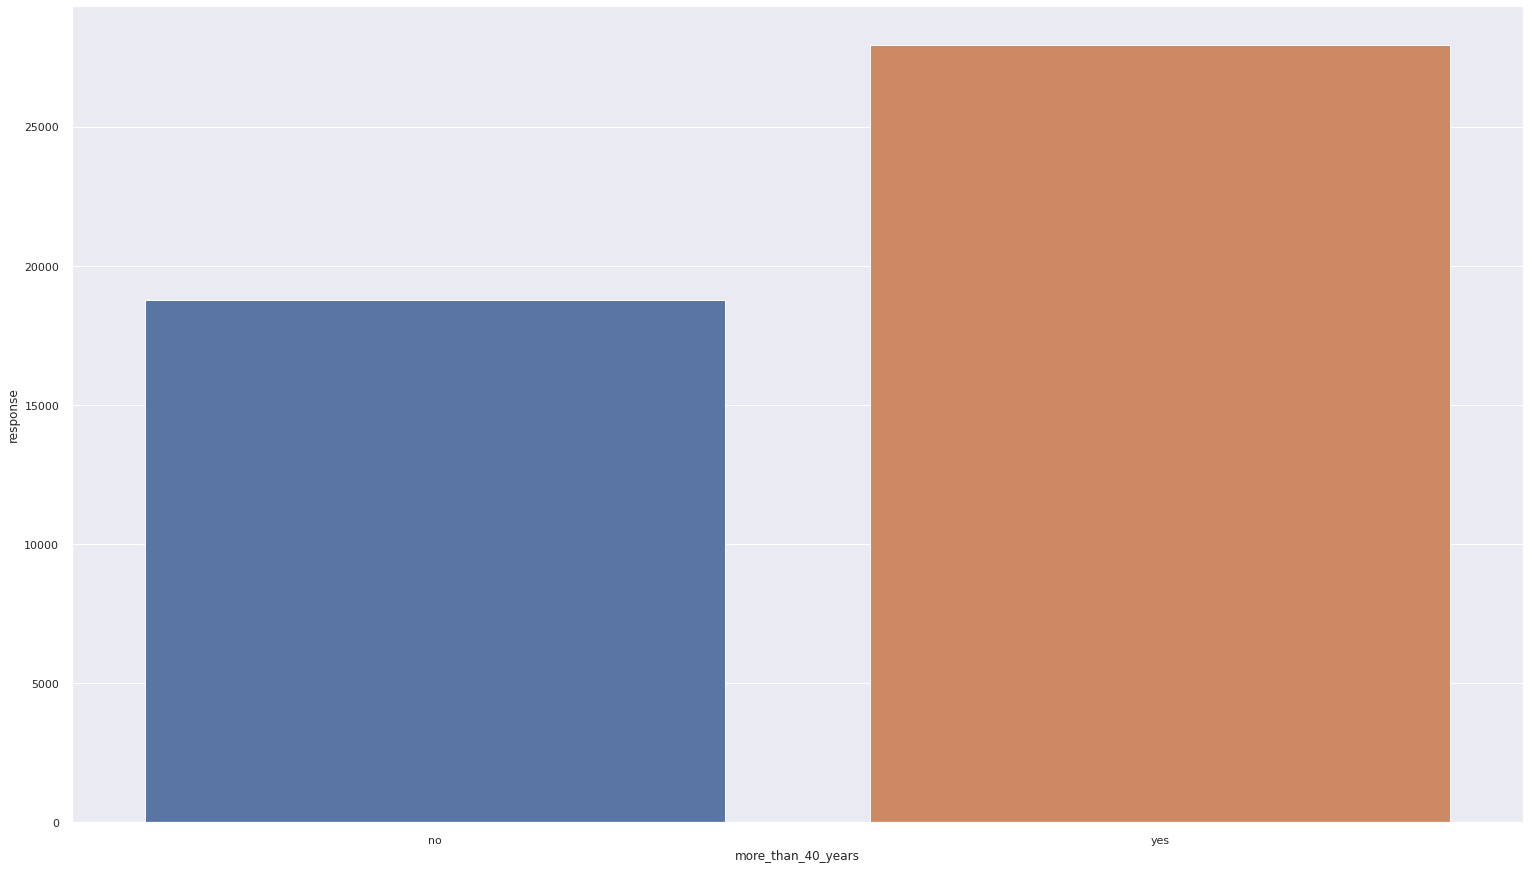

In [39]:
# grouping
aux2 = df3[['more_than_40_years', 'response']].groupby('more_than_40_years').sum().reset_index()

# calculing the percentual
tot1 = aux2['response'].sum()
perc1 = int(aux2['response'].head(1))/tot1
perc2 = int(aux2['response'].tail(1))/tot1
maj1 = 100*(perc2 - perc1)
print('      **People with more than 40 years have more {:.2f}% chance to buy a health'
      ' insurance than youngest people.**'.format(maj1))

# ploting graph
sns.barplot(data=aux2, x='more_than_40_years', y='response');

### **H3.** People with driving license have more chance to purchase a car insurance. (Insight to model)
**TRUE** People with driving license have more 99.82% chance to purchase a car insurance than people who don't have it.

      People with driving license have more 99.82% chance to purchase a health insurance than people who don't have it.


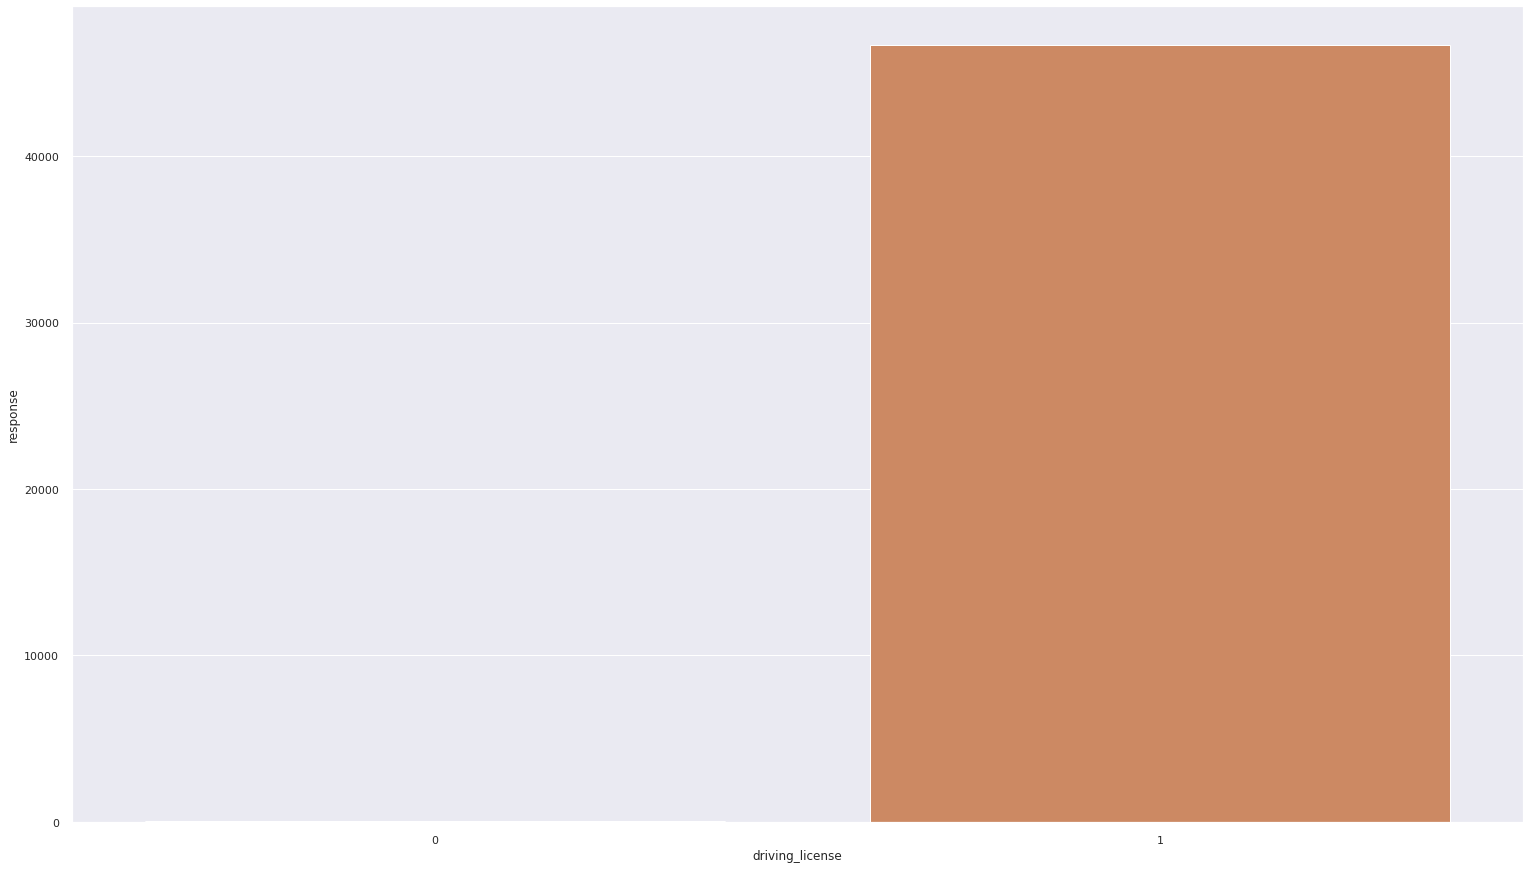

In [40]:
# grouping
aux2 = df3[['driving_license', 'response']].groupby('driving_license').sum().reset_index()

# calculing the percentual
tot1 = aux2['response'].sum()
perc1 = int(aux2['response'].head(1))/tot1
perc2 = int(aux2['response'].tail(1))/tot1
maj1 = 100*(perc2 - perc1)
print('      People with driving license have more {:.2f}% chance to purchase a health'
      " insurance than people who don't have it.".format(maj1))

# ploting graph
sns.barplot(data=aux2, x='driving_license', y='response');

### H4. People that previously insured a health insurance have more chance to purchase a car insurance.
**FALSE** People who didn't previously insured a health insurance have more 99.32% chance to purchase a car insurance than people who don't have it.

      People who didn't previously insured a health insurance have more 99.32% chance to purchase a health         insurance than people who don't have it.


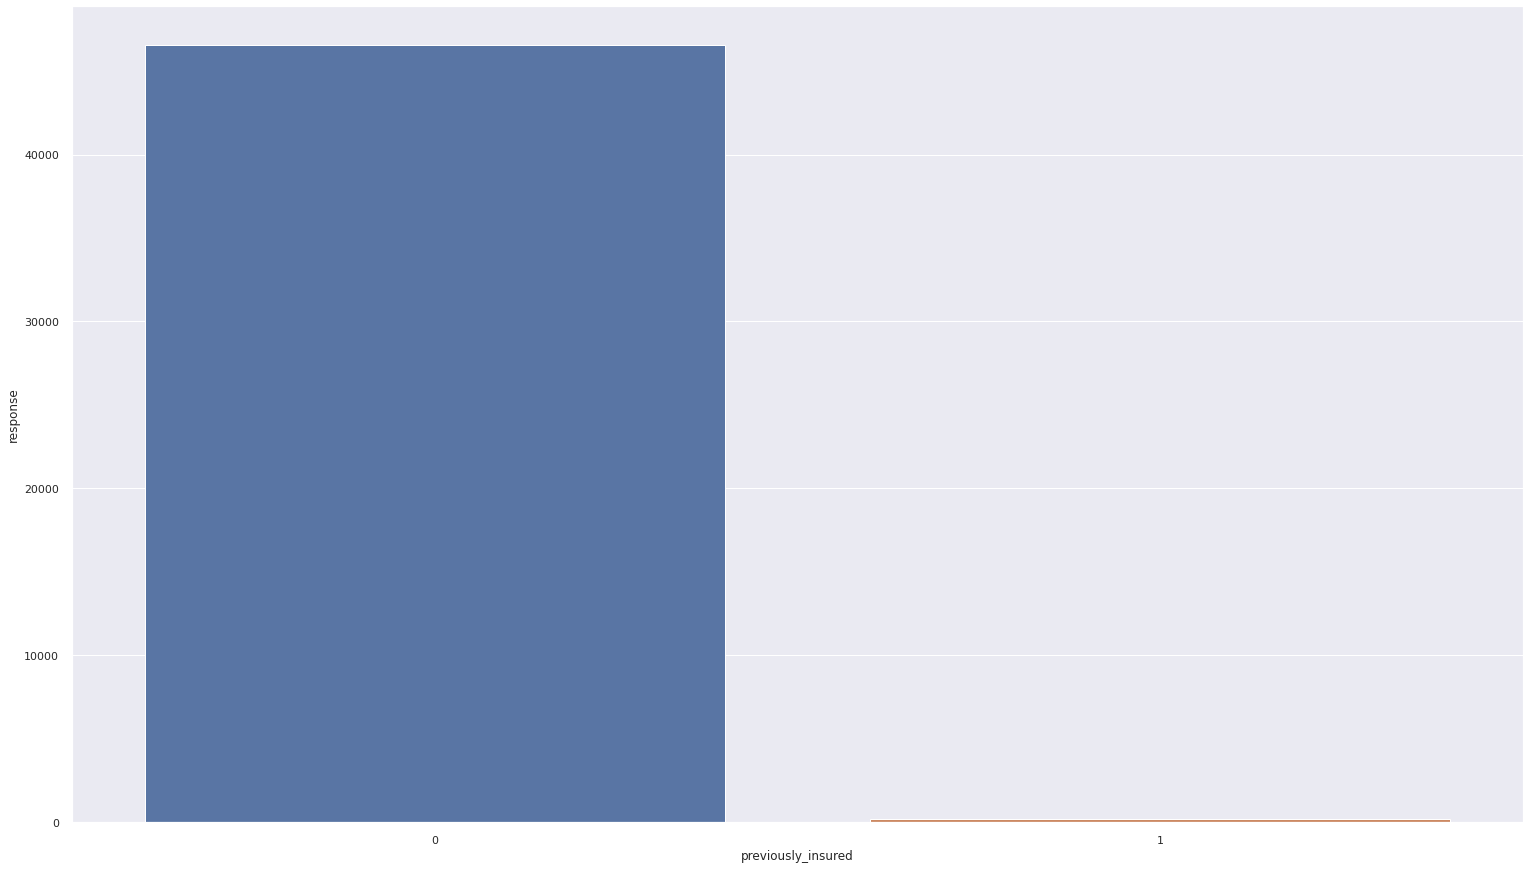

In [41]:
# grouping
aux2 = df3[['previously_insured', 'response']].groupby('previously_insured').sum().reset_index()

# calculing the percentual
tot1 = aux2['response'].sum()
perc1 = int(aux2['response'].head(1))/tot1
perc2 = int(aux2['response'].tail(1))/tot1
maj1 = 100*(perc1 - perc2)
print("      People who didn't previously insured a health insurance have more {:.2f}% chance to purchase a health"
      "         insurance than people who don't have it.".format(maj1))

# ploting graph
sns.barplot(data=aux2, x='previously_insured', y='response');

### H5. People with vehicles with a age less than 2 have more chance to purchase a car insurance. (INSIGHT)
**TRUE** People with vehicles with a age less than 2 have more chance to purchase a car insurance.

      People who have a car for less than two year have more 79.87% chance to purchase a health         insurance than people who don't have it.


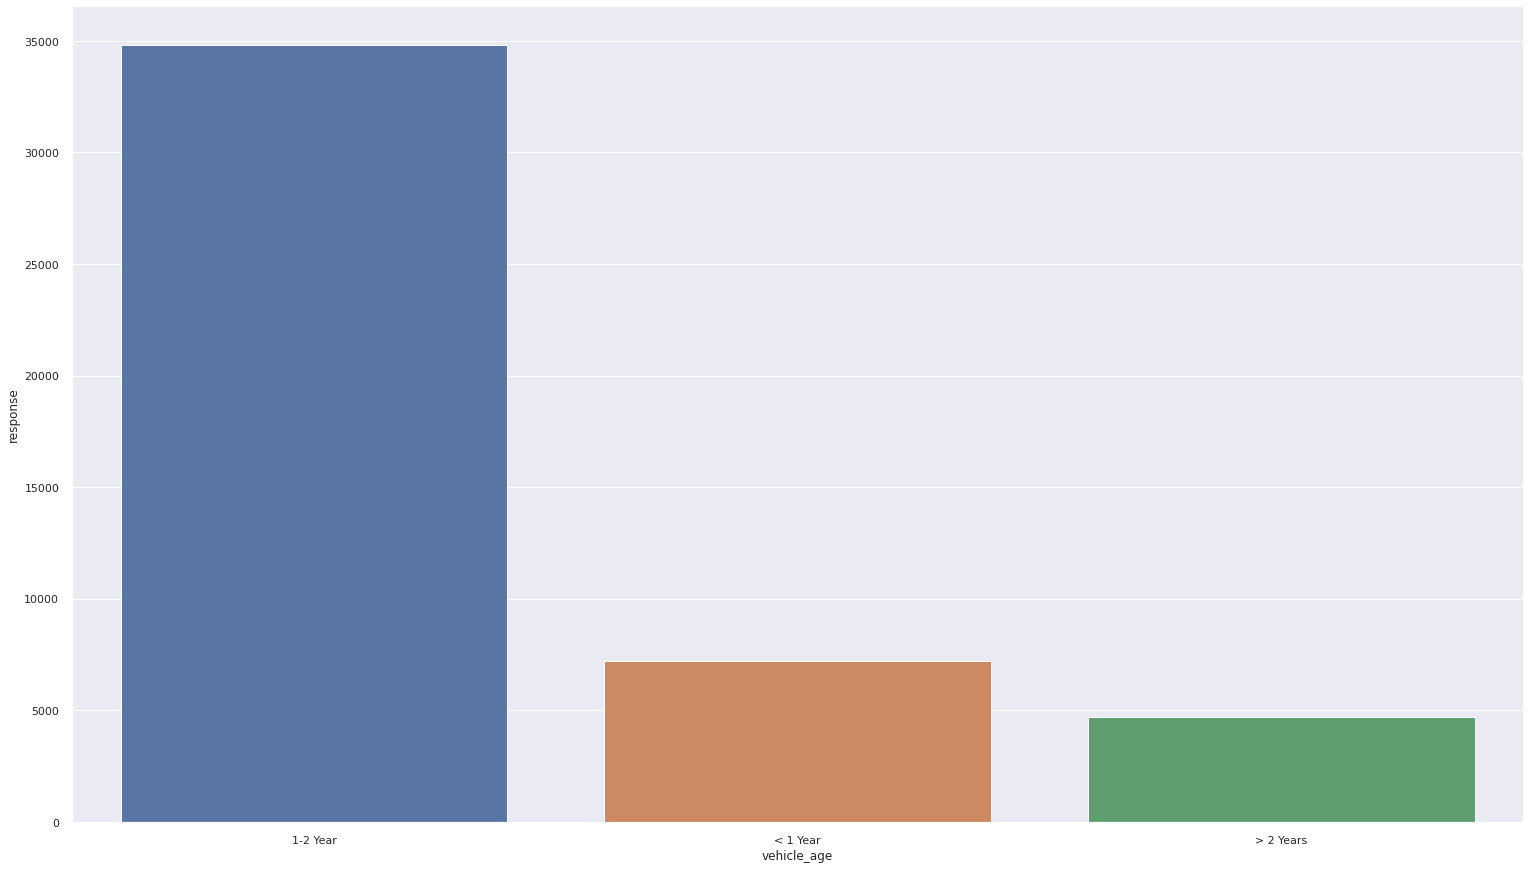

In [42]:
# grouping
aux2 = df3[['vehicle_age', 'response']].groupby('vehicle_age').sum().reset_index()

# calculing the percentual
tot1 = aux2['response'].sum()
perc1 = (aux2.iloc[0, 1] + aux2.iloc[1, 1])/tot1
perc2 = aux2.iloc[2, 1]/tot1
maj1 = 100*(perc1 - perc2)
print("      People who have a car for less than two year have more {:.2f}% chance to purchase a health"
      "         insurance than people who don't have it.".format(maj1))

# ploting graph
sns.barplot(data=aux2, x='vehicle_age', y='response');

### H6. People with a annual premium lower than 41,000.00 have more chance to purchase a car insurance. (INSIGHT)
**TRUE** People with vehicles with annual premiums lower than 41.000 have more chance to purchase a car insurance.

      People who have a car for less than two year have more 48.56% chance to purchase a health         insurance than people who don't have it.


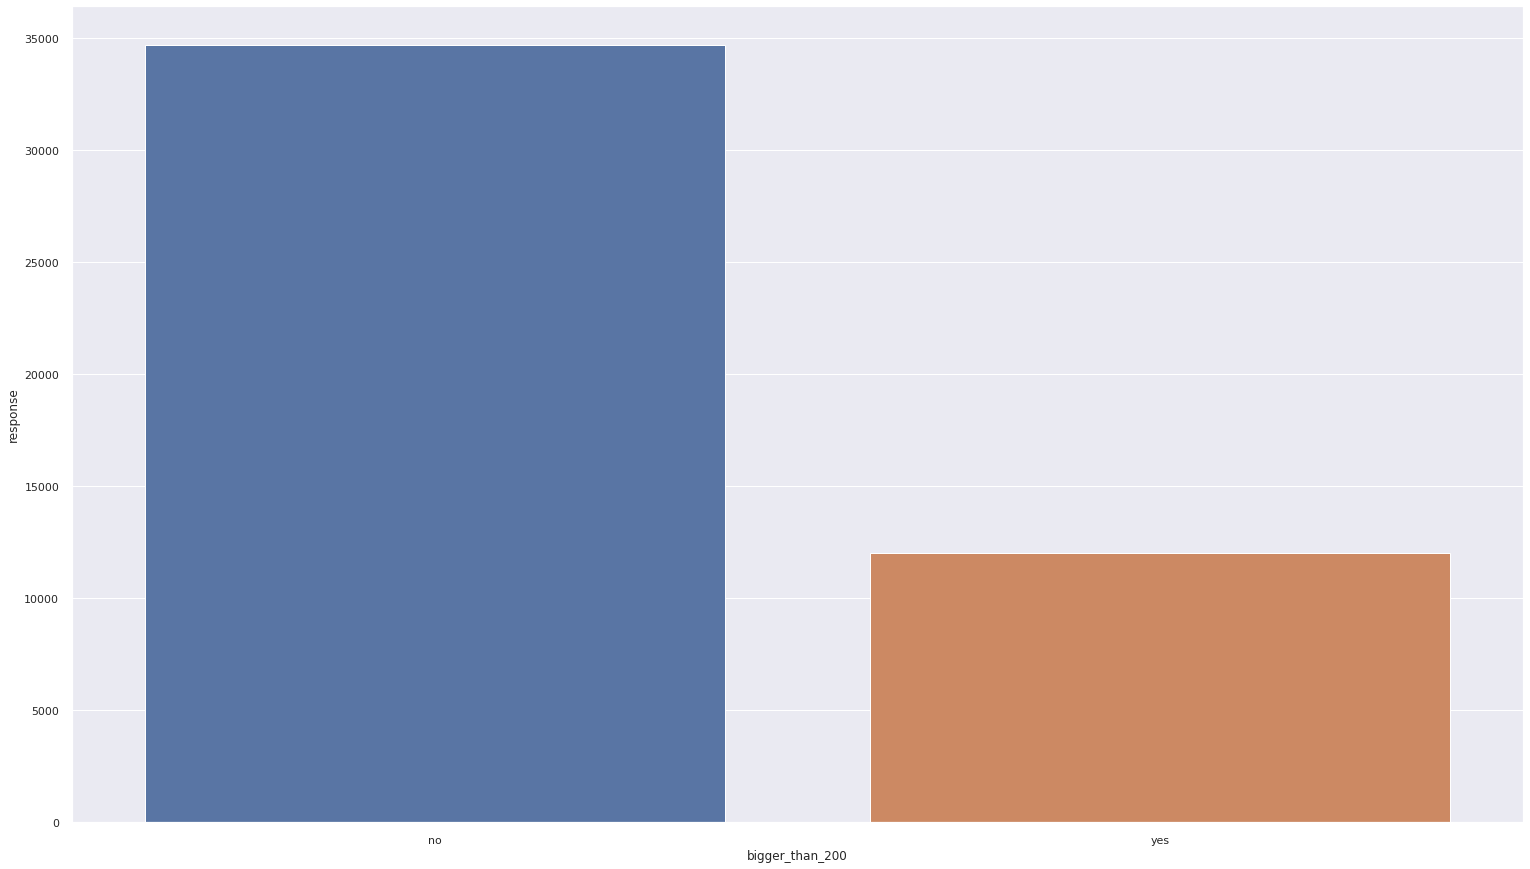

In [43]:
# grouping
aux1 = df3.copy()
aux1['bigger_than_200'] = df3['annual_premium'].apply(lambda x: 'yes' if x >= 41000 else 'no')
aux2 = aux1[['bigger_than_200', 'response']].groupby('bigger_than_200').sum().reset_index()

# calculing the percentual
tot1 = aux2['response'].sum()
perc1 = int(aux2['response'].head(1))/tot1
perc2 = int(aux2['response'].tail(1))/tot1
maj1 = 100*(perc1 - perc2)
print("      People who have a car for less than two year have more {:.2f}% chance to purchase a health"
      "         insurance than people who don't have it.".format(maj1))

# ploting graph
sns.barplot(data=aux2, x='bigger_than_200', y='response');

### H7. People associated to the company for more than 200 days have more chance to purchase a car insurance. (INSIGHT)
**FALSE** People associated to the company for less than 200 days have less chance to purchase a car insurance.

      People who have a car for less than two year have more 31.22% chance to purchase a car         insurance than people who don't have it.


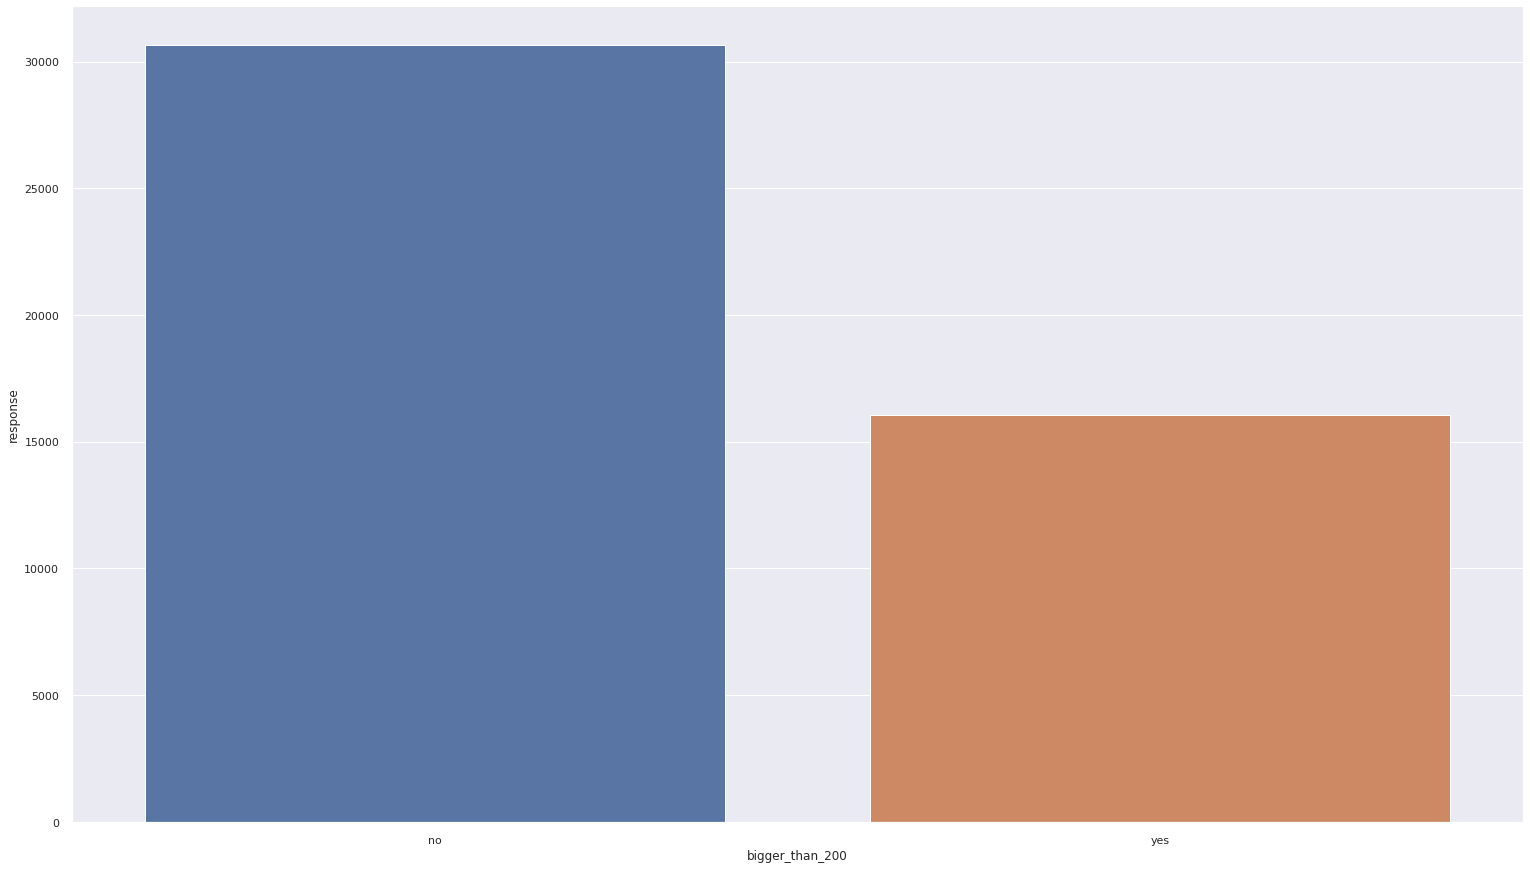

In [44]:
# grouping
aux1 = df3.copy()
aux1['bigger_than_200'] = df3['vintage'].apply(lambda x: 'yes' if x >= 200 else 'no')
aux2 = aux1[['bigger_than_200', 'response']].groupby('bigger_than_200').sum().reset_index()

# calculing the percentual
tot1 = aux2['response'].sum()
perc1 = int(aux2['response'].head(1))/tot1
perc2 = int(aux2['response'].tail(1))/tot1
maj1 = 100*(perc1 - perc2)
print("      People who have a car for less than two year have more {:.2f}% chance to purchase a car"
      "         insurance than people who don't have it.".format(maj1))

# ploting graph
sns.barplot(data=aux2, x='bigger_than_200', y='response');

### **H8.** People that lives in a risk region have more chance to purchase a car insurance.
**TRUE** People in risk region have more chance to purchase a car insurance.

      People who live in risk regions have more 10.57% chance to purchase a car         insurance than people who don't have it.


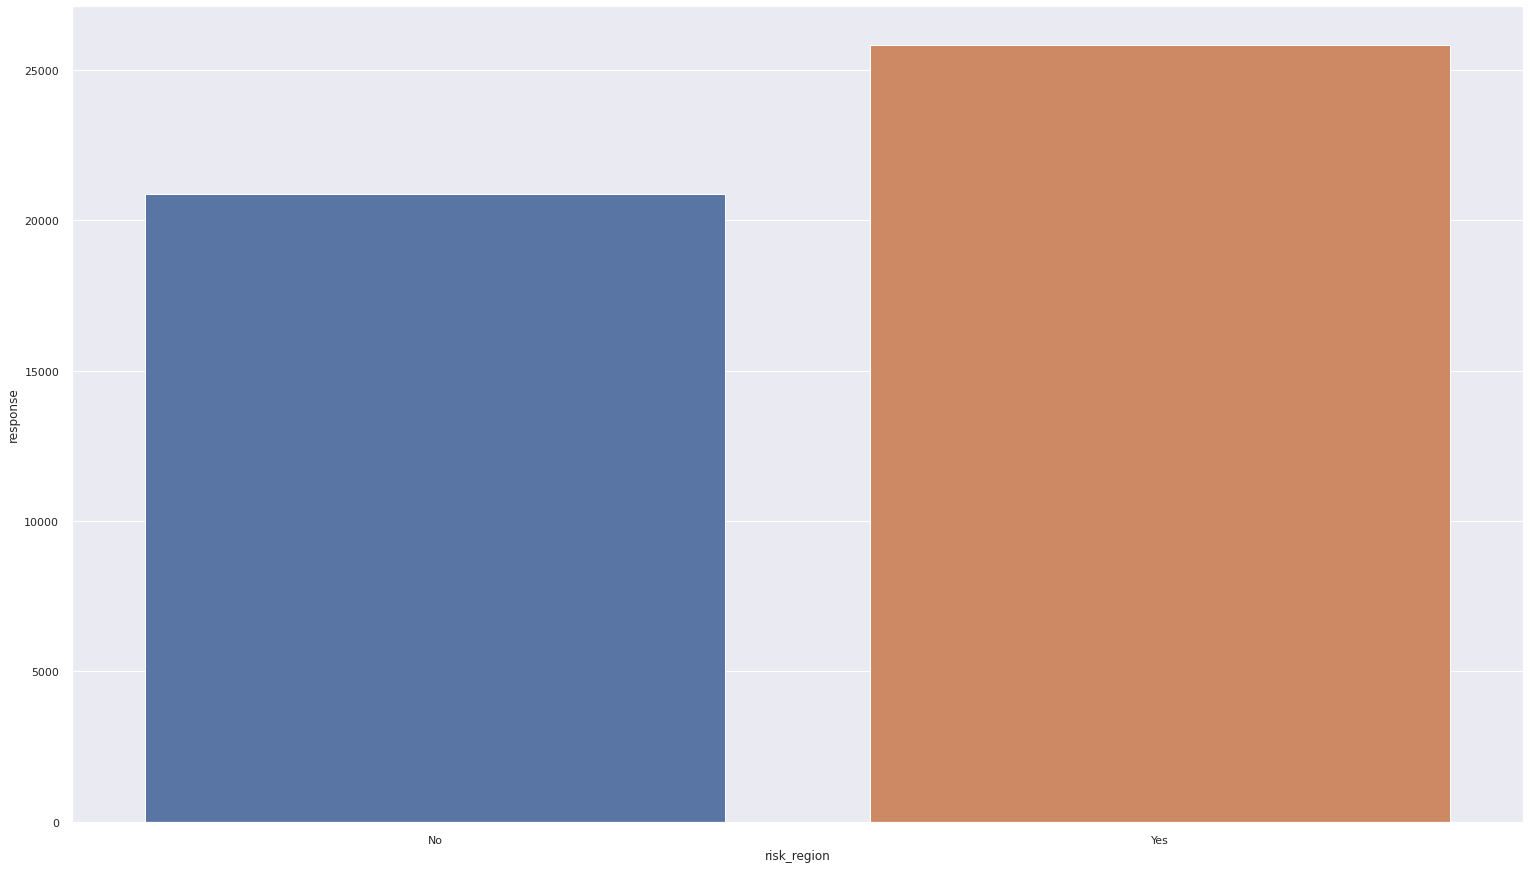

In [45]:
# grouping
aux2 = df3[['risk_region', 'response']].groupby('risk_region').sum().reset_index()

# calculing the percentual
tot1 = aux2['response'].sum()
perc1 = aux2.iloc[1, 1]/tot1
perc2 = aux2.iloc[0, 1]/tot1
maj1 = 100*(perc1 - perc2)
print("      People who live in risk regions have more {:.2f}% chance to purchase a car"
      "         insurance than people who don't have it.".format(maj1))

# ploting graph
sns.barplot(data=aux2, x='risk_region', y='response');

## 3.3. Multivariable Analysis

In [46]:
# separating numerical attributes
num_attributes2 = df3.select_dtypes(include=['int64', 'float64'])

# separating categorical attributes
cat_attributes2 = df3.select_dtypes(exclude=['int64', 'float64'])

### 3.3.1. Numerical Variables

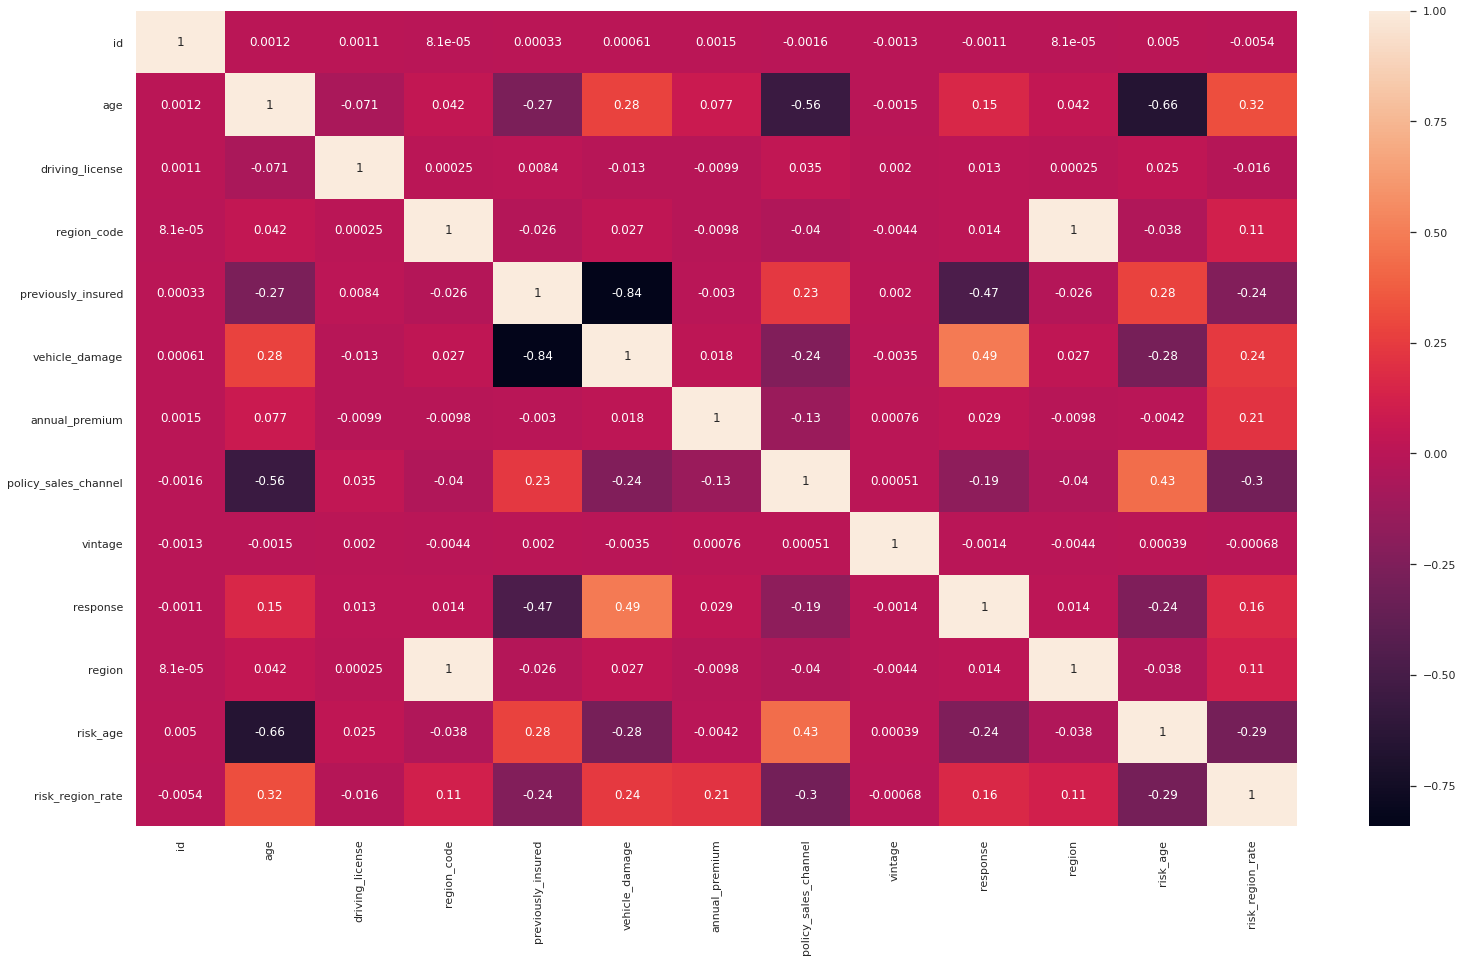

In [47]:
# numerical attributes
sns.heatmap(data=num_attributes2.corr(), annot=True);

### 3.3.2. Categorical Attributes

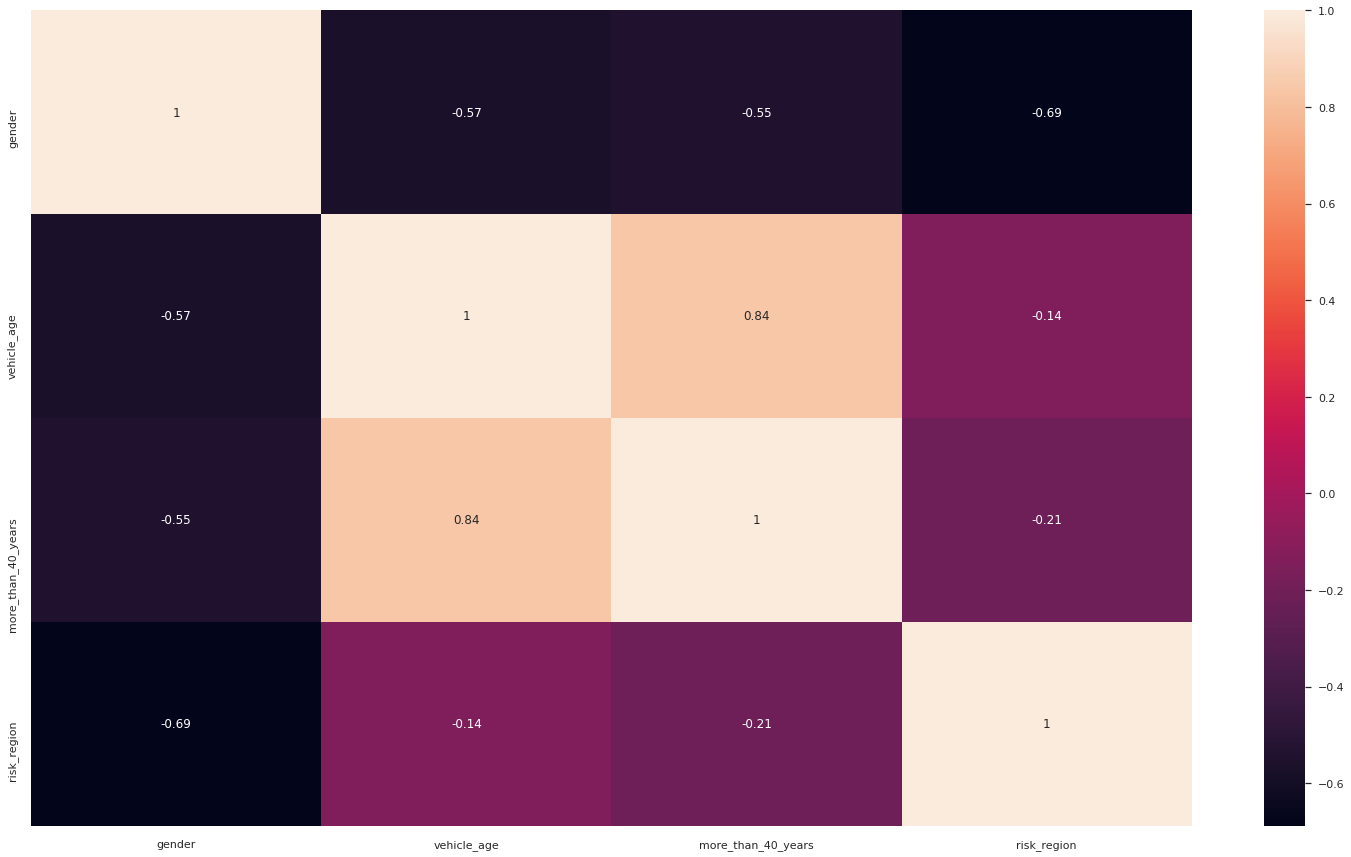

In [48]:
aux=pd.DataFrame(corr_cramer_v(cat_attributes2))
sns.heatmap(data=aux.corr(), annot=True);

## 3.4. Relevant Features

I'm judging that the relevant features are: **driving_license, previously_insured, risk_age, age, vehicle_age and more_than_40_years, risk_region_rate.**

In [49]:
# saving features
manual = ['vintage', 'annual_premium', 'region_code', 'driving_license', 'previously_insured', 'risk_age', 'age', 'vehicle_age', 'more_than_40_years', 'risk_region_rate']

# 4.0. Step 04 - Data Filtering

In [50]:
# copying dataset
df4 = df3.copy()

## 4.1. Columns Filtering

Here was dropped some features that can't help in the predict model.

In [51]:
# selecting columns to drop
cols = ['region']

# creting function
def dropcols1(df, cols):
    
    df = df.drop(cols, axis=1)
    
    return df

In [52]:
# dropping columns in the train dataset
df4 = dropcols1(df4, cols)

# 5.0. Step 05 - Data Preparation

In [53]:
# predict variables
X = df4.drop(columns = ['response'], axis = 1)
#target variable
y = df4['response']

# split data
df5, df5_test, y_train, y_val = train_test_split(X, y , test_size = 0.2, random_state = 42)

# copying "id"
idsTrain = df5['id'].copy()
idsTest = df5_test['id'].copy()

# dropping "id"
df5 = df5.drop('id', axis=1)
df5_test = df5_test.drop('id', axis=1)

**Features Per Method**

RobustScaler = ['annual_premium']

MinMaxScaler = ['age', 'vintage', 'risk_region_rate', 'region_code', 'policy_sales_channel']

Normal_Enconder = ['gender', 'risk_region', 'more_than_40_years']

One_Hot_Enconder = ['vehicle_age']

## 5.1. Rescalling

In [54]:
# scallers selected
rs=pp.RobustScaler()
mms=pp.MinMaxScaler()

In [55]:
# ---------------------------------RobustScaler-------------------------------------------
df5['annual_premium'] = rs.fit_transform(df5[['annual_premium']].values)
pickle.dump(rs, open('scalers/annual_premium_scaler.pkl', 'wb'))

# ---------------------------------MinMaxScaler-------------------------------------------
df5['age'] = mms.fit_transform(df5[['age']].values)
pickle.dump(mms, open('scalers/age_scaler.pkl', 'wb'))

df5['vintage'] = mms.fit_transform(df5[['vintage']].values)
pickle.dump(mms, open('scalers/vintage_scaler.pkl', 'wb'))

df5['policy_sales_channel'] = mms.fit_transform(df5[['policy_sales_channel']].values)
pickle.dump(mms, open('scalers/policy_sales_channel_scaler.pkl', 'wb'))

df5['risk_region_rate'] = mms.fit_transform(df5[['risk_region_rate']].values)
pickle.dump(mms, open('scalers/risk_region_rate_scaler.pkl', 'wb'))

df5['region_code'] = mms.fit_transform(df5[['region_code']].values)
pickle.dump(mms, open('scalers/region_code_scaler.pkl', 'wb'))

## 5.2. Enconding

### 5.2.1. Normal Enconder

In [56]:
# Enconding

df5['gender'] = df5['gender'].apply(lambda x: 1 if x == 'Male' else 0)

df5['risk_region'] = df5['risk_region'].apply(lambda x: 1 if x == 'Yes' else 0)

df5['more_than_40_years'] = df5['more_than_40_years'].apply(lambda x: 1 if x == 'yes' else 0)

### 5.2.2. One Hot Enconder

In [57]:
# getting dummies
df5 = pd.get_dummies(df5, prefix=['vehicle_age'], columns=['vehicle_age'])

## 5.3. Rescalling Test Dataset

In [58]:
# ---------------------------------RobustScaler-------------------------------------------
rs = pickle.load(open('scalers/annual_premium_scaler.pkl', 'rb'))
df5_test['annual_premium'] = rs.transform(df5_test[['annual_premium']].values)

# ---------------------------------MinMaxScaler-------------------------------------------
mms = pickle.load(open('scalers/age_scaler.pkl', 'rb'))
df5_test['age'] = mms.transform(df5_test[['age']].values)

mms = pickle.load(open('scalers/vintage_scaler.pkl', 'rb'))
df5_test['vintage'] = mms.transform(df5_test[['vintage']].values)

mms = pickle.load(open('scalers/policy_sales_channel_scaler.pkl', 'rb'))
df5_test['policy_sales_channel'] = mms.transform(df5_test[['policy_sales_channel']].values)

mms = pickle.load(open('scalers/risk_region_rate_scaler.pkl', 'rb'))
df5_test['risk_region_rate'] = mms.transform(df5_test[['risk_region_rate']].values)

mms = pickle.load(open('scalers/region_code_scaler.pkl', 'rb'))
df5_test['region_code'] = mms.transform(df5_test[['region_code']].values)

## 5.4. Enconding Test Dataset

### 5.4.1. Normal Encoding

In [59]:
# Enconding

df5_test['gender'] = df5_test['gender'].apply(lambda x: 1 if x == 'Male' else 0)

df5_test['risk_region'] = df5_test['risk_region'].apply(lambda x: 1 if x == 'Yes' else 0)

df5_test['more_than_40_years'] = df5_test['more_than_40_years'].apply(lambda x: 1 if x == 'yes' else 0)

### 5.4.2. One Hot Encoding

In [60]:
# getting dummies
df5_test = pd.get_dummies(df5_test, prefix=['vehicle_age'], columns=['vehicle_age'])

# 6.0. Step 06 - Feature Selection

In [61]:
# Copying Datasets
X_train = df5.copy()
X_val = df5_test.copy()

# Concat Data for Selection
X = pd.concat([X_train, X_val], axis=0)
y = pd.concat([y_train, y_val], axis=0)

## 6.1. Random Forest as Feature Selector (Feature Importance)

Text(0.5, 1.0, 'Feature Importance')

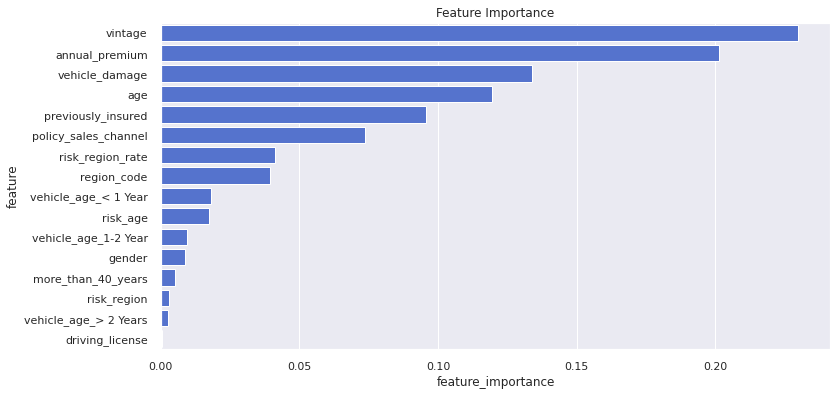

In [62]:
# train random forest classifier
rf = ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )
rf.fit(X, y)

# feature importance data frame
feat_sel = pd.DataFrame({'feature': X.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)


# plot feature importance
plt.subplots(figsize=(12,6))
rf_plot = sns.barplot(x='feature_importance', y='feature', data=feat_sel, orient='h', color='royalblue')\
            .set_title('Feature Importance');
rf_plot

In [63]:
forest = feat_sel.iloc[:8]

## 6.2. Boruta as Feature Selector (Auto Select)

In [64]:
# adaptando dados de treino
#x_train_n = X.values

#y_train_n = y.values.ravel()

# define RandomForestRegressor
#rf = RandomForestClassifier( n_estimators = 10, criterion = 'entropy', random_state = 42 )

#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n )

In [65]:
# colunas selecionadas
#cols_selected = boruta.support_.tolist()

# melhores features de acordo com o Boruta
#x_train_fs = X_train
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# features não selecionadas pelo Boruta
#cols_not_selected_boruta = list( np.setdiff1d ( x_train_fs.columns, cols_selected_boruta ))
cols_selected_boruta = pickle.load(open('models/boruta.pkl', 'rb'))
cols_selected_boruta
#pickle.dump(cols_selected_boruta, open('models/boruta.pkl', 'wb'))

['previously_insured', 'vehicle_damage']

## 6.3. Manual Feature Selection

In [66]:
forest

,feature,feature_importance
0,vintage,0.23
1,annual_premium,0.20
2,vehicle_damage,0.13
3,age,0.12
4,previously_insured,0.10
5,policy_sales_channel,0.07
6,risk_region_rate,0.04
7,region_code,0.04


In [67]:
manual

['vintage',
 'annual_premium',
 'region_code',
 'driving_license',
 'previously_insured',
 'risk_age',
 'age',
 'vehicle_age',
 'more_than_40_years',
 'risk_region_rate']

In [68]:
cols_selected_boruta

['previously_insured', 'vehicle_damage']

In [69]:
final_cols = ['vintage',
             'annual_premium',
             'region_code',
              'vehicle_damage',
              'policy_sales_channel',
             'driving_license',
             'previously_insured',
             'age',
             'more_than_40_years',
             'risk_region_rate']

# 7.0. Step 07 - Machine Learning Modeling

In [70]:
# restricting datasets
X_train = X_train[final_cols]
X_val = X_val[final_cols]
X = X[final_cols]

In [71]:
models_list=pd.DataFrame()

## 7.1. K-Nearest Neighbours

### 7.1.1. Train and Test

In [72]:
# defining model
knn_model = nh.KNeighborsClassifier(n_neighbors=7)
models_list[0] = knn_model

# training model
knn_model.fit(X_train, y_train)

# testing model
yhat_knn = knn_model.predict_proba(X_val)

### 7.1.2. Performance

<Figure size 720x432 with 0 Axes>

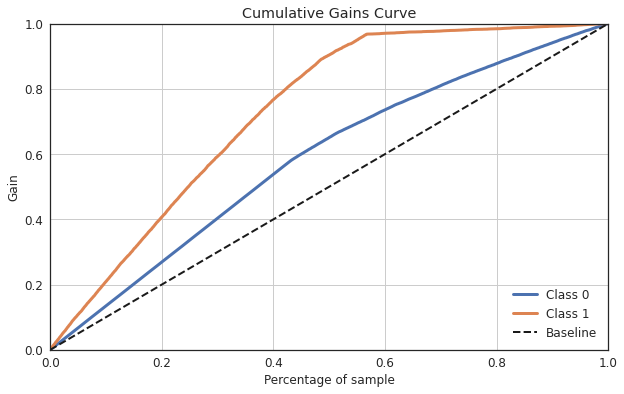

In [73]:
#Accumaltive Gain
with plt.style.context("seaborn-white"):
    plt.figure(figsize(10, 6))
    skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

<Figure size 720x432 with 0 Axes>

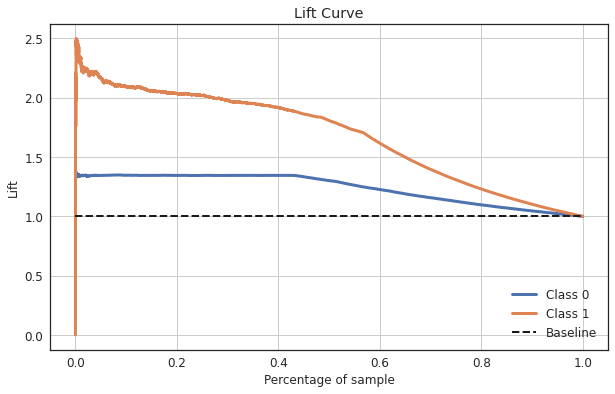

In [74]:
#lifc Curve
with plt.style.context("seaborn-white"):
    plt.figure(figsize(10, 6))
    skplt.metrics.plot_lift_curve(y_val,yhat_knn);

In [75]:
# ROC Auc Curve


## 7.2. XGBoost Classifier

### 7.2.1. Train and Test

In [76]:
# defining model
xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                                  eval_metric='error',
                                  n_estimators=100,
                                  eta=0.01,
                                  max_depth=10,
                                  subsample=0.7,
                                  colsample_bytree=0.9)

models_list[1] = xgb_model

# training model
xgb_model.fit(X_train, y_train)

# testing model
yhat_xgb = xgb_model.predict_proba(X_val)

### 7.2.2. Performance

<Figure size 720x432 with 0 Axes>

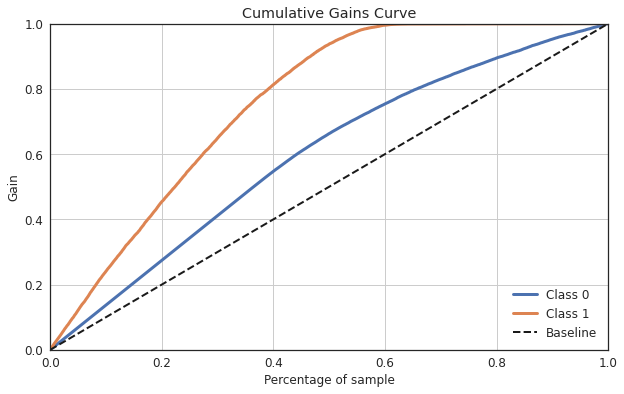

In [77]:
#Accumaltive Gain
with plt.style.context("seaborn-white"):
    plt.figure(figsize(10, 6))
    skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb);

<Figure size 720x432 with 0 Axes>

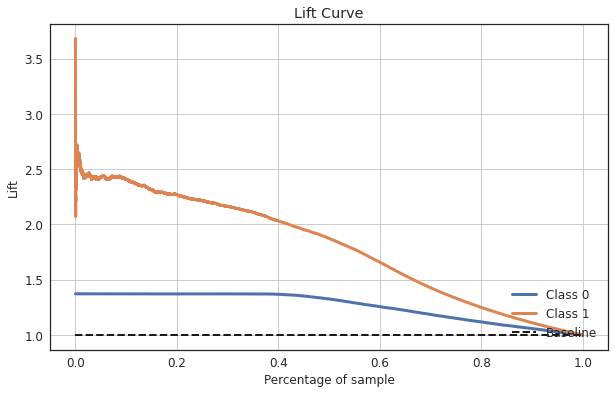

In [78]:
#lifc curve
with plt.style.context("seaborn-white"):
    plt.figure(figsize(10, 6))
    skplt.metrics.plot_lift_curve(y_val,yhat_xgb);

## 7.3. LGBM Classifier

### 7.3.1. Train and Test

In [79]:
# defining model
lgbm = LGBMClassifier(n_jobs = -1, max_depth=10)
models_list[2] = lgbm

# training model
lgbm.fit(X_train, y_train)

# testing model
yhat_lgbm = lgbm.predict_proba(X_val)

### 7.2.2. Performance

<Figure size 720x432 with 0 Axes>

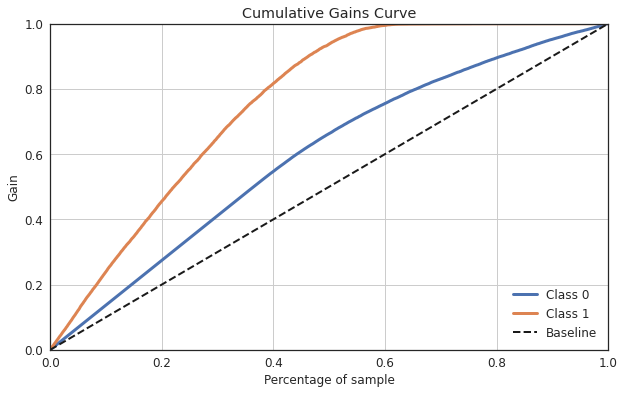

In [80]:
#Accumaltive Gain
with plt.style.context("seaborn-white"):
    plt.figure(figsize(10, 6))
    skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm);

<Figure size 720x432 with 0 Axes>

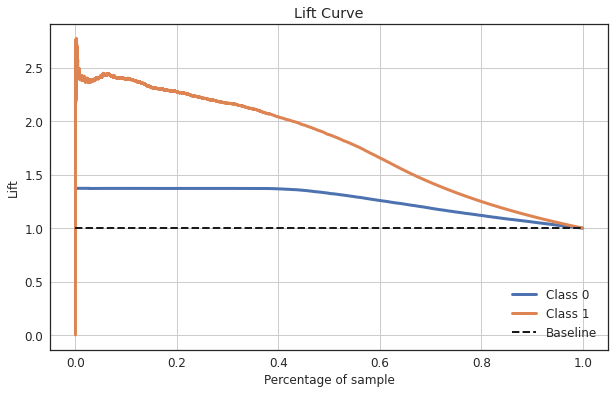

In [81]:
#lifc curve
with plt.style.context("seaborn-white"):
    plt.figure(figsize(10, 6))
    skplt.metrics.plot_lift_curve(y_val,yhat_lgbm);

## 7.4. Naive Bayes

### 7.4.1. Train and Test

In [82]:
# defining model
nb_model = GaussianNB()
models_list[3] = nb_model

# training model
nb_model.fit(X_train, y_train)

# testing model
yhat_nb = nb_model.predict_proba(X_val)

### 7.4.2. Performance

<Figure size 720x432 with 0 Axes>

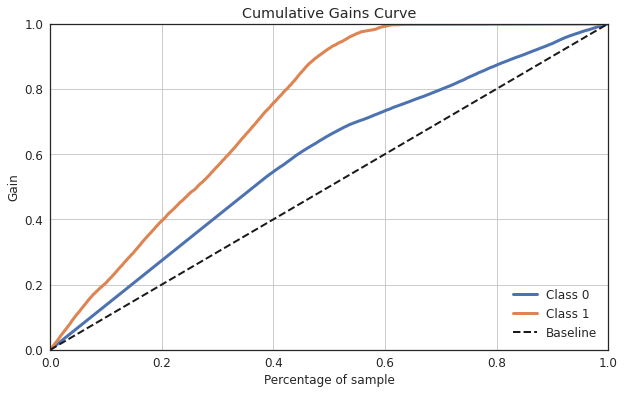

In [83]:
#Accumaltive Gain
with plt.style.context("seaborn-white"):
    plt.figure(figsize(10, 6))
    skplt.metrics.plot_cumulative_gain(y_val, yhat_nb);

<Figure size 720x432 with 0 Axes>

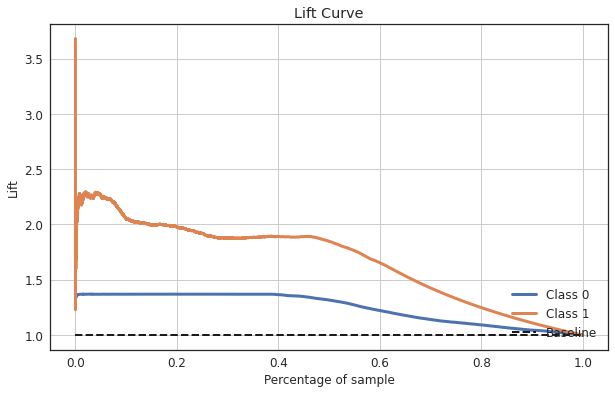

In [84]:
#lifc curve
with plt.style.context("seaborn-white"):
    plt.figure(figsize(10, 6))
    skplt.metrics.plot_lift_curve(y_val,yhat_nb);

## 7.5. Random Forest

### 7.5.1. Train and Test

In [85]:
# defining model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
#models_list[4] = rf_model

# training model
rf_model.fit(X_train, y_train)

# testing model
yhat_rf = rf_model.predict_proba(X_val)

### 7.5.2. Performance

<Figure size 720x432 with 0 Axes>

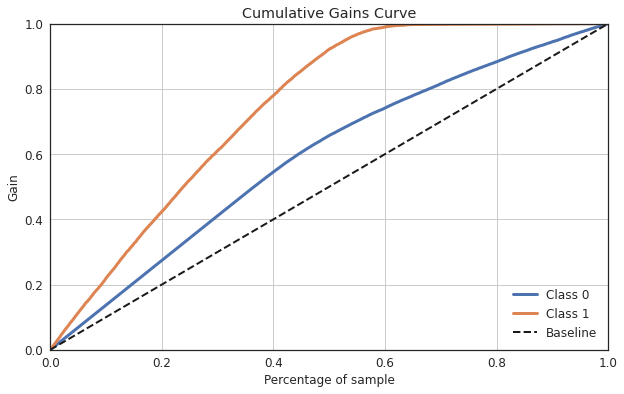

In [86]:
#Accumaltive Gain
with plt.style.context("seaborn-white"):
    plt.figure(figsize(10, 6))
    skplt.metrics.plot_cumulative_gain(y_val, yhat_rf);

<Figure size 720x432 with 0 Axes>

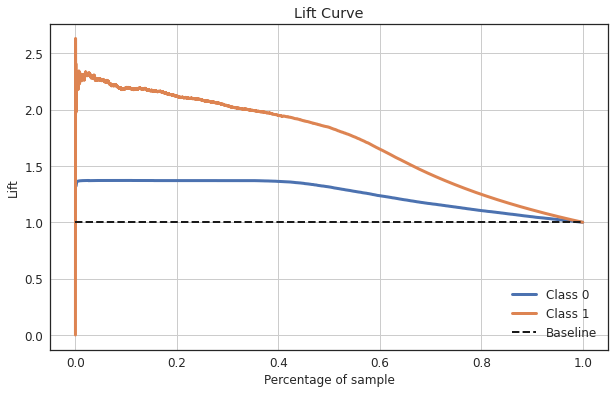

In [87]:
#lifc curve
with plt.style.context("seaborn-white"):
    plt.figure(figsize(10, 6))
    skplt.metrics.plot_lift_curve(y_val,yhat_rf);

## 7.6. Models Performance

In [88]:
models_performance=pd.DataFrame()
models_list=[
                xgb.XGBClassifier(objective='binary:logistic',
                                  eval_metric='error',
                                  n_estimators=100,
                                  eta=0.01,
                                  max_depth=10,
                                  subsample=0.7,
                                  colsample_bytree=0.9),
                GaussianNB(),
                RandomForestClassifier(n_estimators=100,random_state=42),
                nh.KNeighborsClassifier(n_jobs=-1),
                LGBMClassifier()
            ]

models_performance=models_performance.append(models_train(models_list,X_train,y_train,X_val,y_val,'predict_proba','binaryClass',0))
models_performance

XGBClassifier
GaussianNB
RandomForestClassifier
KNeighborsClassifier
LGBMClassifier


,Index,Model,ROC AUC,Top K Score
0,0,XGBClassifier,0.86,0.78
0,0,GaussianNB,0.82,0.70
0,0,RandomForestClassifier,0.84,0.76
0,0,KNeighborsClassifier,0.81,0.75
0,0,LGBMClassifier,0.86,0.78


### 7.6.1. Cumulative Gain

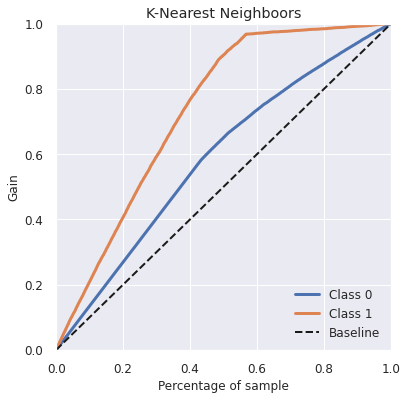

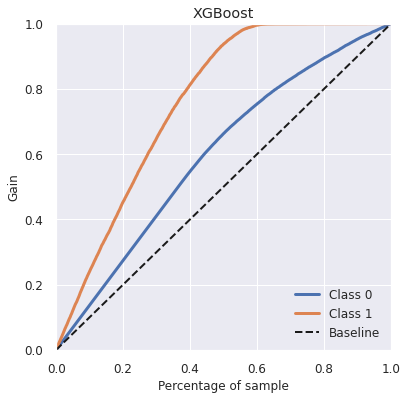

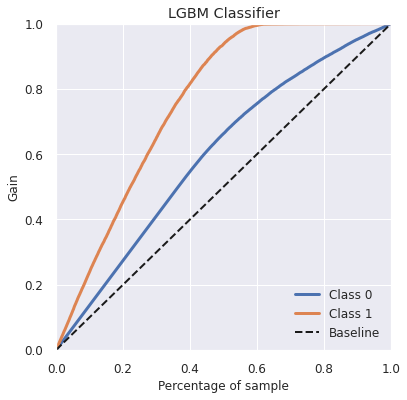

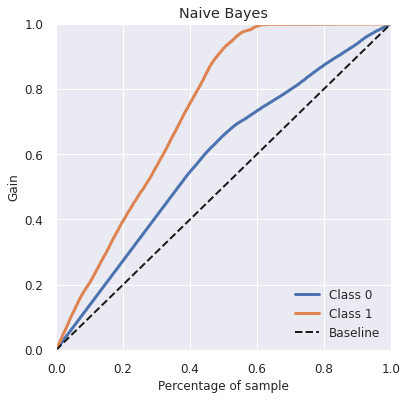

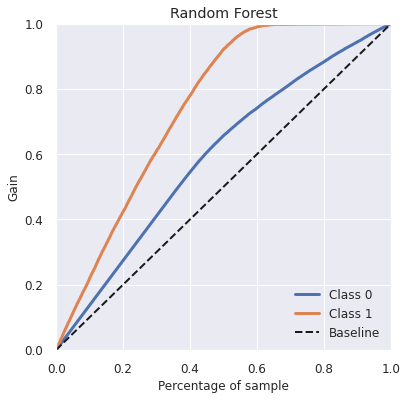

In [89]:
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn,figsize =(6,6),title='K-Nearest Neighboors');
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb,figsize =(6,6),title='XGBoost');
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm,figsize =(6,6),title='LGBM Classifier');
skplt.metrics.plot_cumulative_gain(y_val, yhat_nb,figsize =(6,6),title='Naive Bayes');
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf,figsize =(6,6),title='Random Forest');

# 8.0. Step 08 - Cross Validation

## 8.1. Models

In [90]:
# K-Nearest Neighbours
models_performance=models_performance.append(cross_validation(5,'KNN',knn_model, X_train,y_train, 'binaryClass'))
 
# XGBoost
models_performance=models_performance.append(cross_validation(5,'XGBoost',xgb_model,X_train,y_train,'binaryClass'))

# LGBM
models_performance=models_performance.append(cross_validation(5,'LGBM',lgbm,X_train,y_train,'binaryClass'))

# Naive Bayes
models_performance=models_performance.append(cross_validation(5,'Naive Bayes',nb_model,X_train,y_train,'binaryClass'))

# Random Forest
models_performance=models_performance.append(cross_validation(5,'Random Forest',rf_model,X_train,y_train,'binaryClass'))

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5
Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5
Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5
Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5
Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


## 8.2. Cross Validation Performance

In [91]:
# changing dtypes
models_performance['ROC AUC'] = models_performance['ROC AUC'].astype(float)
models_performance['Top K Score'] = models_performance['Top K Score'].astype(float)

# dropping index column
models_performance = models_performance.drop('Index', axis=1)

# mean performances
general_perf = models_performance.groupby('Model').mean().reset_index()
general_perf

,Model,ROC AUC,Top K Score
0,GaussianNB,0.79,0.70
1,KNeighborsClassifier,0.70,0.75
2,LGBMClassifier,0.75,0.78
3,RandomForestClassifier,0.71,0.76
4,XGBClassifier,0.74,0.78


# 9.0. Step 09 - Hyperparameter Fine Tuning

## 9.1. Random Search

In [92]:
max_eval=20

hp_result=pd.DataFrame()

lgbm_parameter = {'num_leaves': (5,15,45,60,90),
                  'max_depth': (5, 7, 10 ),
                  'min_split_gain': (0.001, 0.01 ,0.1),
                  'min_child_weight': (10,30,40,50),
                  'min_child_weight':(14, 20,30),
                  'subsample':(0.5, 1),
                  'colsample_bytree':(0.1, 1)
                 }

In [93]:
for i in range (max_eval):
    #escolher parametro aleatoriamente
    hp = {k: rd.sample(v,1)[0] for k,v in lgbm_parameter.items()}
    print(hp)
    model_lgbm = LGBMClassifier(num_leaves=hp['num_leaves'],
                                  max_depth=hp['max_depth'],
                                  min_split_gain=hp['min_split_gain'],
                                  min_child_weight=hp['min_child_weight'],
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree']).fit(X_train,y_train)

    yhat_lgbm=model_lgbm.predict_proba(X_val)
    lgbm_result_hp=ranking_class_metrics('LGBM -'+str(i),y_val,yhat_lgbm[:,1],0)
    hp_result=pd.concat([hp_result,lgbm_result_hp])
hp_result

{'num_leaves': 5, 'max_depth': 5, 'min_split_gain': 0.1, 'min_child_weight': 20, 'subsample': 1, 'colsample_bytree': 1}
{'num_leaves': 5, 'max_depth': 10, 'min_split_gain': 0.001, 'min_child_weight': 20, 'subsample': 1, 'colsample_bytree': 0.1}
{'num_leaves': 90, 'max_depth': 7, 'min_split_gain': 0.001, 'min_child_weight': 20, 'subsample': 1, 'colsample_bytree': 0.1}
{'num_leaves': 15, 'max_depth': 5, 'min_split_gain': 0.001, 'min_child_weight': 14, 'subsample': 0.5, 'colsample_bytree': 1}
{'num_leaves': 15, 'max_depth': 10, 'min_split_gain': 0.001, 'min_child_weight': 20, 'subsample': 0.5, 'colsample_bytree': 0.1}
{'num_leaves': 45, 'max_depth': 7, 'min_split_gain': 0.001, 'min_child_weight': 14, 'subsample': 0.5, 'colsample_bytree': 1}
{'num_leaves': 5, 'max_depth': 10, 'min_split_gain': 0.01, 'min_child_weight': 20, 'subsample': 0.5, 'colsample_bytree': 0.1}
{'num_leaves': 45, 'max_depth': 7, 'min_split_gain': 0.1, 'min_child_weight': 20, 'subsample': 1, 'colsample_bytree': 1}
{'num

,Index,Model,ROC AUC,Top K Score
0,0,LGBM -0,0.86,0.78
0,0,LGBM -1,0.85,0.78
0,0,LGBM -2,0.85,0.78
0,0,LGBM -3,0.86,0.78
0,0,LGBM -4,0.85,0.78
0,0,LGBM -5,0.86,0.78
0,0,LGBM -6,0.85,0.78
0,0,LGBM -7,0.86,0.78
0,0,LGBM -8,0.85,0.78
0,0,LGBM -9,0.86,0.78


## 9.2. Final Model

### 9.2.1. Model

In [94]:
# defining model
#lgbm = LGBMClassifier(num_leaves=15, max_depth=7, min_split_gain=0.01, 
#                     min_child_weight=20, subsample=1, colsample_bytree=1)

# training model
#lgbm.fit(X_train, y_train)
#pickle.dump(lgbm, open('models/lgbm_final.pkl', 'wb'))
lgbm = pickle.load(open('models/lgbm_final.pkl', 'rb'))

# testing model
yhat_lgbm = lgbm.predict_proba(X_val)

# performance values
lgbm_perf = ranking_class_metrics('LGBM',y_val,yhat_lgbm[:,1],0)
lgbm_perf

,Index,Model,ROC AUC,Top K Score
0,0,LGBM,0.86,0.78


### 9.2.2. All Data Model

In [95]:
# treinando com todos os dados

# concat dados totais
X = pd.concat([X_train, X_val], axis=0)
y = pd.concat([y_train, y_val], axis=0)

# redefinindo modelo
lgbm = LGBMClassifier(num_leaves=15, max_depth=7, min_split_gain=0.01, 
                      min_child_weight=20, subsample=1, colsample_bytree=1)

# training model
lgbm.fit(X, y)
pickle.dump(lgbm, open('models/lgbm_final1.pkl', 'wb'))

### 9.2.3. Performance

<Figure size 720x432 with 0 Axes>

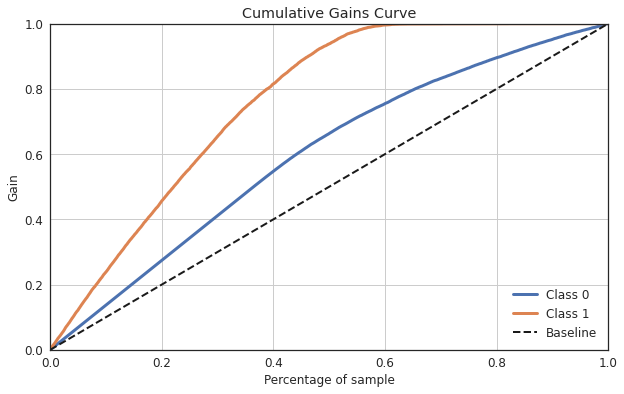

In [96]:
#Accumaltive Gain
with plt.style.context("seaborn-white"):
    plt.figure(figsize(10, 6));
    skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm);

<Figure size 720x432 with 0 Axes>

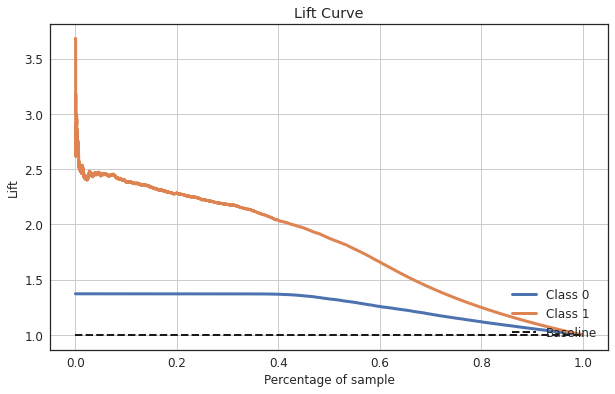

In [97]:
#lifc curve
with plt.style.context("seaborn-white"):
    plt.figure(figsize(10, 6))
    skplt.metrics.plot_lift_curve(y_val,yhat_lgbm);

# 10.0. Step 10 - Business Performance

Now I will answer the questions from the CEO.

In [98]:
# recovering id columns
X_val['id'] = idsTest.copy()

# recovering response
X_val['response'] = y_val.copy()

# validation date
df_validated = validation_data(lgbm, X_val)

### 1 - Main insights about the features more relevant from clients interesteds in purchase a car insurance.

1. people with vehicles with a age less than 2 have more chance to purchase a car insurance.

2. People with vehicles with annual premiums lower than 41.000 have more chance to purchase a car insurance.

3. People associated to the company for less than 200 days have less chance to purchase a car insurance.

### 2 - What's the percentage of clients interesteds in purchase a car insurance, if the sales team will be able to just contact 10.000 customers?

The percentage will be approximately 62% of all the interested clients.

In [99]:
# calculing recall at k
metrics = validation_metrics(df_validated, 10000)
metrics

,ranking_metrics
precision_at_10000,0.60
recall_at_10000,0.63


### 3 - If the capacity of the sales team growh up to 20.000 calls, which will be the percentage of clients interesteds in purchase a car insurance that the sales team will be able to contact?

The percentage will be approximately 99% of all the interested clients.

In [100]:
# calculing recall at k
metrics = validation_metrics(df_validated, 20000)
metrics

,ranking_metrics
precision_at_20000,0.47
recall_at_20000,0.99


### 4 - How many call the sales team will need to do to contact 80% of the customers interests in purchase a car insurance?

The marketing team will call 80% of the interested customers if they call 13772 people.

In [101]:
interested_80 = df_validated[df_validated['recall_at_k'] >= 0.8].index.min()
interested_80

13449

### 5. What's the minimum score I need to address to get the greatest return?
The minimum score to call is 0.087 second the test dataset.

<Figure size 720x432 with 0 Axes>

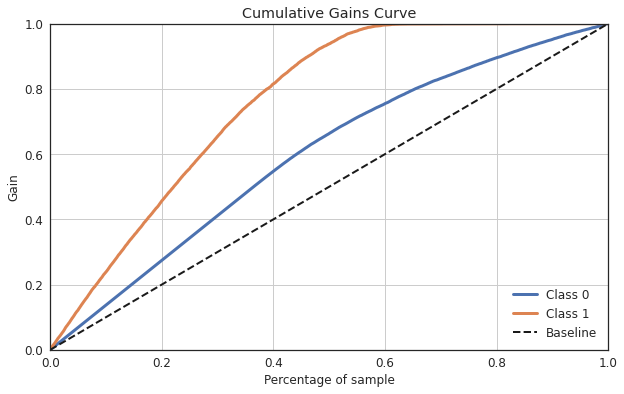

In [128]:
#Accumaltive Gain
with plt.style.context("seaborn-white"):
    plt.figure(figsize(10, 6));
    skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm);

I'm considering the sample percentage of 58%, because it look like the best end according the curve.

In [129]:
# checking the quantity of 55% from the sample
len(yhat_lgbm)*0.58

20173.559999999998

In [130]:
# adjusting data
aux = pd.DataFrame(yhat_lgbm).iloc[:, 1].reset_index()

# sorting and dropping data
aux1 = aux.sort_values(1, ascending=False).drop('index', axis=1)

# getting the 60% best examples
aux2 = aux1.head(20175)

# getting the minimum score to call
min(aux2[1])

0.08720068480943674

# 11.0. Step 11 - Deployment

## 11.1. Insurance All Class

In [102]:
import pickle
import pandas as pd
import numpy as np
import inflection
from sklearn.preprocessing  import RobustScaler, MinMaxScaler

class InsuranceAll(object):
    
    def __init__(self):
        
        self.aps = pickle.load(open('scalers/annual_premium_scaler.pkl', 'rb'))
        self.age = pickle.load(open('scalers/age_scaler.pkl', 'rb'))
        self.vs = pickle.load(open('scalers/vintage_scaler.pkl', 'rb'))
        self.pscs = pickle.load(open('scalers/policy_sales_channel_scaler.pkl', 'rb'))
        self.rrrs = pickle.load(open('scalers/risk_region_rate_scaler.pkl', 'rb'))
        self.rcs = pickle.load(open('scalers/region_code_scaler.pkl', 'rb'))
                        
    def feature_engineering(self, df):
    
        risk_regions = [0,  1,  4,  5,  7, 19, 20, 23, 24, 26, 28, 31, 34, 37, 38, 39, 40,
           42, 43, 47, 48, 49, 51]
	
        # risk_age
        df['risk_age'] = df['age'].apply(lambda x: 0 if x > 25 else 1)

        # more_than_40_years
        df['more_than_40_years'] = df['age'].apply(lambda x: 'yes' if x > 40 else 'no')

        #------------------------------------------------------------------------------------------------------
        # summing vehicle_damage by region_code
        aux = df.copy()
        aux['vehicle_damage'] = aux['vehicle_damage'].apply(lambda x: 0 if x == 'No' else 1)
        aux1 = aux[['region_code', 'vehicle_damage']].groupby('region_code').sum().reset_index()

        # counting regions' appearences
        df['region'] = df['region_code'].copy()
        aux4 = df[['region_code', 'region']].groupby('region_code').count().reset_index().drop('region_code', axis=1)
        aux5 = pd.concat([aux4, aux1], axis=1)

        # derivating the rate of risk region
        aux5['risk_region_rate'] = aux5['vehicle_damage']/aux5['region']

        # derivating rate - region variable to merge
        aux7 = aux5.copy()
        aux7 = aux7.drop(['region', 'vehicle_damage'], axis=1)
        aux7['risk_region_rate'] = aux7['risk_region_rate']*1000

        # merging datasets
        df = pd.merge(aux, aux7, how='left', on='region_code')

        #---------------------------------------------------------------------------------------------------------

        # risk_region
        df['risk_region'] = df['region_code'].apply(lambda x: 'Yes' if x in risk_regions else 'No')
        
        return df

                      
    def data_rescale(self, df):
        
        df['annual_premium'] = self.aps.transform(df[['annual_premium']].values)
        df['age'] = self.age.transform(df[['age']].values)
        df['vintage'] = self.vs.transform(df[['vintage']].values)
        df['policy_sales_channel'] = self.pscs.transform(df[['policy_sales_channel']].values)
        df['risk_region_rate'] = self.rrrs.transform(df[['risk_region_rate']].values)
        df['region_code'] = self.rcs.transform(df[['region_code']].values)
        
        return df
    
    def data_encoding(self, df):
        
        df['more_than_40_years'] = df['more_than_40_years'].apply(lambda x: 1 if x == 'yes' else 0)
        df = pd.get_dummies(df, prefix=['vehicle_age'], columns=['vehicle_age'])
        
        cols_selected = ['vintage', 'annual_premium', 'region_code',
              'vehicle_damage', 'policy_sales_channel', 'driving_license',
             'previously_insured', 'age', 'more_than_40_years', 'risk_region_rate']
        
        return df[cols_selected]

    def get_prediction(self, model, original_data, test_data):
        
        # model prediction
        pred = model.predict_proba( test_data )

        # join prediction into original data
        original_data['prediction'] = pred[:, 1]

        return original_data.to_json( orient='records', date_format='iso' ) 

## 11.2. API Handler

In [103]:
import pickle
import pandas as pd
import os

from sklearn.preprocessing  import RobustScaler, MinMaxScaler
from flask import Flask, request, Response
from insuranceAll.InsuranceAll import InsuranceAll

model = pickle.load(open('model.pkl','rb'))

app = Flask(__name__)
@app.route('/predict', methods=['POST'])

def insurance_all_predict():
    test_json= request.get_json()
    
    if test_json:
        
        if isinstance(test_json,dict):
            test_raw=pd.DataFrame(test_json,index=[0])
        else:
            test_raw=pd.DataFrame(test_json,columns=test_json[0].keys())
               
        pipeline = InsuranceAll()
        df = test_raw.copy()
        df = pipeline.feature_engineering(df)
        df = pipeline.data_rescale(df)
        df = pipeline.data_encoding(df)
        df_response = pipeline.get_prediction(model, test_raw, df)
        
        return df_response
    
    else:
        return Response('{}', status=200, mimetype='application/json')

    
if __name__ == '__main__':
    port = int(os.environ.get("PORT", 5000))
    app.run(host='0.0.0.0', port=port)

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on all addresses.
 * Running on http://192.168.15.9:5000/ (Press CTRL+C to quit)
 * Restarting with watchdog (inotify)


SystemExit: 1

## 11.3. Google Sheet Integration

All the code above is in "javascript" then it don't function here in "python".

In [ ]:
#PA004 Health Insurance Cross-Sell
function onOpen(){
  var ui = SpreadsheetApp.getUi();
  ui.createMenu( 'Valcilio PA004' )
    .addItem('Get Prediction', 'PredictAll')
    .addToUi();
};

host_production = 'insu-all-heal-car.herokuapp.com'

#Helper Function
function ApiCall(data, endpoint){
  var url = 'https://' + host_production + endpoint;
  var payload = JSON.stringify(data);

  var options = {'method': 'POST', 'contentType': 'application/json', 'payload':payload};
  
  var response = UrlFetchApp.fetch(url, options);

  # get response
  var rc = response.getResponseCode();
  var responseText = response.getContentText();

  if (rc !== 200){
    Logger.log('Response (%s) %s', rc, responseText)
  }
  else{
    prediction = JSON.parse(responseText);
  };

  return prediction

};

function PredictAll(){
  var ss = SpreadsheetApp.getActiveSheet();
  var titleColumns = ss.getRange('A1:L1').getValues()[0];
  var lastRow = ss.getLastRow();

  var data = ss.getRange('A2' + ':' + 'L' + lastRow).getValues();

  # run over all rows
  for (row in data){
    var json = new Object();

    # run over all columns
    for(var j=0; j < titleColumns.length; j++){
      json[titleColumns[j]] = data[row][j];
    };

    # List of Json to send
    var json_send = new Object();

    json_send['id'] = json['id']
    json_send['gender'] = json['gender']
    json_send['age'] = json['age']
    json_send['driving_license'] = json['driving_license']
    json_send['region_code'] = json['region_code']
    json_send['previously_insured'] = json['previously_insured']
    json_send['vehicle_age'] = json['vehicle_age']
    json_send['vehicle_damage'] = json['vehicle_damage']
    json_send['annual_premium'] = json['annual_premium']
    json_send['policy_sales_channel'] = json['policy_sales_channel']
    json_send['vintage'] = json['vintage']

    pred = ApiCall(json_send, '/predict');

    # Send back to google sheets
    ss.getRange(Number(row) + 2, 12).setValue(pred[0]['prediction'])

  };
};